## Figure Creation Notebook

This notebook is not runnable with the provided setup in the main data replication notebook, as it relies on intermediate results and data in large scale only available on our database and cloud storage.

## Package imports

In [25]:
# Standard libraries
import ast  # Safely evaluates a string as a Python literal
import json
import math
import re
from datetime import datetime
from io import BytesIO, StringIO

# Data manipulation libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, to_rgba
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.image as mpimg  

# Geospatial libraries
import rasterio
from rasterio.warp import transform
from shapely.geometry import Point
from shapely.ops import nearest_points
import cartopy.crs as ccrs
import cartopy.io.img_tiles as tiles
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.basemap import Basemap
from owslib.wms import WebMapService
import geemap

# Database libraries
import mysql.connector
from sqlalchemy import create_engine

# Image processing
from PIL import Image
import PIL  # Needed if you're using PIL.Image explicitly
Image.MAX_IMAGE_PIXELS = None

# Google Cloud
from google.cloud import storage
client = storage.Client()

# Import statements that may have been commented out
#from functions_activityForValidation import *
from MAI2023.main import *

def identifyMktDays_validation(df,minRank, threshold_for_market): # identify market days based on detected areas and their threshold values
    #print('minRank: ', minRank, ', Threshold_for_market: ', threshold_for_market)
    # List all maximum threshold values on the days-of-week where we detected something and that detection falls below a threshold 
    min_thres_by_day = df[df['strictnessRank'] <= threshold_for_market].groupby('weekdayThisAreaIsActive')['strictnessRank'].min()
    #print('strictness rank and active weekdays',min_thres_by_day)
    # Find the clearest detection 
    lowest_thres = min_thres_by_day.min()
    #print('lowest strictness rank',lowest_thres)
    # Filter unique days of week where the threshold is within 3 ranks of the lowest threshold value -> identifies all similarly high detections
    localMktDays = list(min_thres_by_day[min_thres_by_day - lowest_thres <= 3].index.unique())
    #print('localMktDays', localMktDays)
    def find_position(weekday):
        try:
            return list(localMktDays).index(weekday)
        except ValueError:
            return -1  # Return 0 if the weekday is not found in the list
    df['pos'] = df['weekday'].apply(find_position)
    df['mktDay'] = None
    df.loc[(df['weekday'] == df['weekdayThisAreaIsActive']) & (df['pos'] >= 0), 'mktDay'] = 1 # detected market day
    df.loc[(df['weekday'] != df['weekdayThisAreaIsActive']) & (df['pos'] == -1), 'mktDay'] = 0 # detected non-market day
    df.loc[(df['weekday'] != df['weekdayThisAreaIsActive']) & (df['pos'] >= 0), 'mktDay'] = 99 # observation of detected market area for a given weekday on a different weekday
    return df, localMktDays


# Color definitions
maincolors = ['#2A9D8F', '#e9c46a', '#e76f51']

# Initialize the Earth Engine API
import ee
ee.Initialize(project='p155mali1')


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


## Figure 1

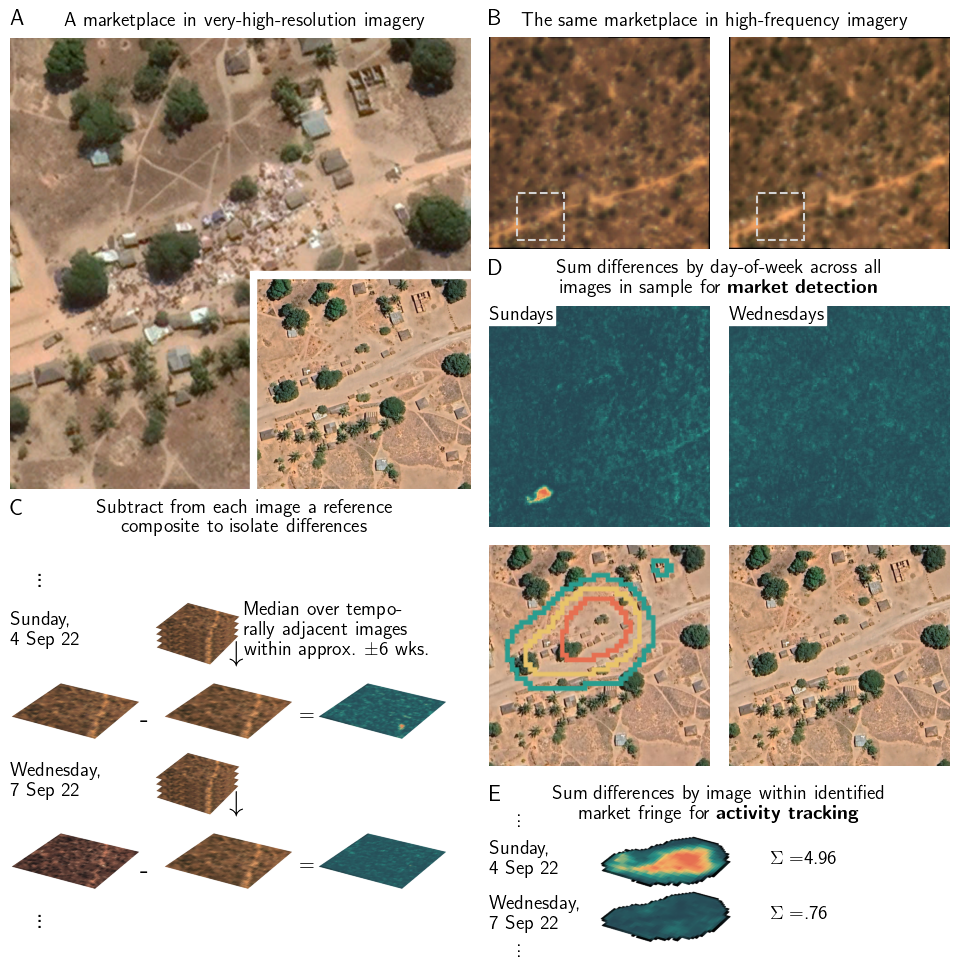

In [17]:
## Parameters ##
fontsize = 14 #4
fs_title=16
# Create a figure with specified dimensions
fig, ax = plt.subplots(figsize=(25/2.54, 25/2.54))  # Convert from cm to inches
plt.rcParams['text.usetex'] = True  # Enable LaTeX

image_paths = ["forFigures/fig1_mkt_highres.png", "forFigures/fig1_nomkt_highres.png", "forFigures/img2.jpeg", "forFigures/img4.jpeg"]
labels = ["Sun, 4 Sep 2022", "Wed, 25 Oct 2023", "Sun, 4 Sep 2022", "Wed, 7 Sep 2022"]
sizes = [.49,.235,.235,.235]
size=0.235
gap = (1- 4*.235)/3

x_corners = [i * (size + gap) for i in range(4)]
y_corners = [1-sizes[0]-gap,1-2*sizes[1]-2*gap,1-sizes[2]-gap,1-sizes[3]-gap]
labelcorners_pre =  [x_corners[0],x_corners[1]+gap/2, x_corners[2:4]]
labelcorners = [item for sublist in labelcorners_pre for item in (sublist if isinstance(sublist, list) else [sublist])]

c=-1
for labcorner, size, path, corner, label, y_corner in zip(labelcorners,sizes, image_paths, x_corners, labels,y_corners):
    c=c+1
    ax.imshow(plt.imread(path), extent=[corner, corner+size, y_corner, y_corner+size-0.01])
    if c==2 or c==3:
        rect = patches.Rectangle((corner+0.03, 1-size-0.01), 0.05, 0.05, linewidth=1.5, edgecolor='lightgrey', facecolor='none', linestyle='dashed')
        ax.add_patch(rect)
    if c==1:
        rect = patches.Rectangle((corner, y_corner), gap/3, 1*size-0.01, edgecolor='white', facecolor='white')
        ax.add_patch(rect)
        rect = patches.Rectangle((corner, y_corner+size-0.01), size,gap/3, edgecolor='white', facecolor='white')
        ax.add_patch(rect)
        
ax.annotate('A', xy=(x_corners[0], 1-gap), xycoords='axes fraction', va='bottom', ha='left', weight='bold', fontsize=fs_title)
ax.annotate('A marketplace in very-high-resolution imagery', xy=(.25, 1-gap), xycoords='axes fraction', va='bottom', ha='center', fontsize=fontsize)
ax.annotate('B', xy=(x_corners[2], 1-gap), xycoords='axes fraction', va='bottom', ha='left', weight='bold', fontsize=fs_title)
ax.annotate('The same marketplace in high-frequency imagery', xy=(.75, 1-gap), xycoords='axes fraction', va='bottom', ha='center', fontsize=fontsize)
top_y =1-size-1.5*gap
top_2 =1-sizes[0]-1.5*gap

ax.annotate('C', xy=(0, top_2), xycoords='axes fraction', va='top', ha='left',  fontweight='bold', fontsize=fs_title)

text = 'Subtract from each image a reference\ncomposite to isolate differences'
ax.annotate(text, xy=(0.25, top_2), xycoords='axes fraction', va='top', ha='center', fontsize=fontsize)

ax.set_facecolor('white')  # Set facecolor to white
ax.axis('off')
ax.set_xlim(0, 1), ax.set_ylim(0, 1)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 


images = ['diffWed.jpeg', 'fig1_nomkt_highres.png','diffSun.jpeg','contourLines.png']
c=-1
hgt_i=0.235
left_x = .5
right_x=1
bottom_y = .5
ax.annotate('Sum differences by day-of-week across all\nimages in sample for \\textbf{market detection}', 
                             xy=(1-hgt_i-gap/2,top_y), xycoords='data', va='top', ha='center', fontsize=fontsize)
key = 1-hgt_i-gap/2
top_3 =top_y-0.01
ax.imshow(plt.imread(f"forFigures/{images[2]}"), extent=[x_corners[2], x_corners[2]+hgt_i, top_3-2*gap-hgt_i, top_3-2*gap])
ax.imshow(plt.imread(f"forFigures/{images[0]}"), extent=[x_corners[3], 1, top_3-2*gap-hgt_i, top_3-2*gap])
ax.imshow(plt.imread(f"forFigures/{images[3]}"), extent=[x_corners[2], x_corners[2]+hgt_i, top_3-3*gap-2*hgt_i, top_3-3*gap-hgt_i])
ax.imshow(plt.imread(f"forFigures/{images[1]}"), extent=[x_corners[3], 1, top_3-3*gap-2*hgt_i, top_3-3*gap-hgt_i])

ax.annotate('Wednesdays', xy=(x_corners[3], top_3-2*gap), xycoords='data', va='top', ha='left', fontsize=fontsize,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.1'))
ax.annotate('Sundays', xy=(x_corners[2],top_3-2*gap), xycoords='data', va='top', ha='left', fontsize=fontsize,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.1'))
ax.annotate('D', xy=(x_corners[2],top_y), xycoords='axes fraction', va='top', ha='left',  fontweight='bold', fontsize=fs_title)


wid = (right_x-2*hgt_i-5*gap) /3  # Height of the plot to occupy (20%)
hei = .3 #image1.shape[1]/image1.shape[0]
siz = 0.05
up =.09
top_y-top_y/3
rows = [top_2-top_2*2/3-0.07, top_2-top_2/3-0.07] 
cols = [0, wid+gap, 2*wid+2*gap]
dates=["Wednesday,\n7 Sep 22", "Sunday,\n4 Sep 22"] #, "Wed, 8 Jun 22"]
cats =["img","comp","diff"]
count=0
for gg, (row, date) in enumerate(zip(rows, dates), start=0):
    ggg=gg+1
    g = row
    cc=-1
    for c in cols:
        count=count+1
        cc = cc+1
        subfig = plt.figure()
        subax = subfig.add_subplot(111, projection='3d')
        if cats[cc]=="comp":
            img = np.fliplr(np.array(Image.fromarray(plt.imread(f"forFigures/{cats[cc]}2.jpeg")).resize((50, 50)).rotate(270)))
        else:
            img = np.fliplr(np.array(Image.fromarray(plt.imread(f"forFigures/{cats[cc]}{ggg}.jpeg")).resize((50, 50)).rotate(270)))
            
        x = np.linspace(0, 1, img.shape[1])
        y = np.linspace(0, 1, img.shape[0])
        X, Y = np.meshgrid(x, y)
        subax.plot_surface(X, Y, np.ones_like(X), facecolors=img/255, rstride=1, cstride=1, shade=False)
        subax.tick_params(left = False, right = False , labelleft = False , 
                        labelbottom = False, bottom = False) 
        subax.set_xlim(0, 1), subax.set_ylim(0, 1), subax.set_zlim(0, 1)
        subax.grid(False), subax.set_axis_off()
        subax.set_xticks([]), subax.set_yticks([]), subax.set_zticks([])
        plt.savefig(f"forFigures/img{count}.png", transparent=True, bbox_inches='tight', pad_inches=0)    
        plt.close(subfig)
        subfig.clf()
        ax.imshow(mpimg.imread(f"forFigures/img{count}.png")[18:210, 15:405,:], extent=[c, c+wid, g-wid/4, g+wid/4])
        if c==0 and gg==1:
            ax.annotate("$\\vdots$", xy=(0.03, g+1.6*up), xycoords='axes fraction', va='center', ha='left', fontsize=20, fontweight='bold')
        if c==0 and gg==0:
            ax.annotate("$\\vdots$", xy=(0.03, g-1.5*wid/3), xycoords='axes fraction', va='bottom', ha='left', fontsize=20, fontweight='bold')
        
    ax.annotate('-', xy=(wid+gap-0.02, g), xycoords='axes fraction',
                             xytext=(wid+gap-0.02, g), va='center', ha='center', fontsize=20)
    ax.annotate('=', xy=(2*wid+1.5*gap, g), xycoords='axes fraction',
                             xytext=(2*wid+1.5*gap, g), va='center', ha='center', fontsize=15)
    
    
    desired_width = 50  # specify your desired width
    desired_height = 50  # specify your desired height
    image1_resized = np.fliplr(np.array(Image.fromarray(plt.imread(f"forFigures/img2.jpeg")).resize((desired_width, desired_height)).rotate(270)))

    # Create figure and 3D axis
    figComp = plt.figure()
    axComp = figComp.add_subplot(111, projection='3d')

    # Create grid
    x = np.linspace(0, 1, image1_resized.shape[1])
    y = np.linspace(0, 1, image1_resized.shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot each image as a surface at different heights
    axComp.plot_surface(X, Y, np.ones_like(X), facecolors=image1_resized/255, rstride=1, cstride=1, shade=False)
    axComp.plot_surface(X, Y, 2 * np.ones_like(X), facecolors=image1_resized/255, rstride=1, cstride=1, shade=False)
    axComp.plot_surface(X, Y, 3 * np.ones_like(X), facecolors=image1_resized/255, rstride=1, cstride=1, shade=False)
    axComp.plot_surface(X, Y, 4 * np.ones_like(X), facecolors=image1_resized/255, rstride=1, cstride=1, shade=False)
    axComp.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 

    axComp.set_xlim(0, 1), axComp.set_ylim(0, 1),  axComp.set_zlim(0, 6)
    axComp.grid(False),axComp.set_axis_off()
    axComp.set_xticks([]), axComp.set_yticks([]), axComp.set_zticks([])
    plt.savefig("forFigures/composite.png", transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close(figComp)
    figComp.clf()

    ax.imshow(mpimg.imread('forFigures/composite.png'), extent=[1.25*wid+gap-siz, 1.25*wid+gap+siz, g+up-siz, g+up+siz])
    if gg!=1:
        #ax.annotate("$med()$", xy=(1.25*wid+gap+siz, g+up), xycoords='axes fraction',va='center', ha='left', fontsize=fontsize)
        pass
    else:
        text = "Median over tempo-\nrally adjacent images\nwithin approx. ±6 wks."
        ax.annotate(text, xy=(1.25*wid+gap+siz, g+up), xycoords='axes fraction', va='center', ha='left', fontsize=fontsize)
    ax.annotate("$\downarrow$", xy=(1.25*wid+gap+siz, g+up-siz/2), xycoords='axes fraction', va='center', ha='right', fontsize=21)
    ax.annotate(date, xy=(0, g+up), xycoords='axes fraction', va='center', ha='left', fontsize=fontsize)

top=top_y-4.5*gap-2*hgt_i
rows = [top*1/3-0.02, top*2/3-0.02]
wid=top/2
ax.annotate('E', xy=(right_x-2*hgt_i-gap,top), xycoords='axes fraction', va='top', ha='left',  fontweight='bold', fontsize=fs_title)
ax.annotate('Sum differences by image within identified\nmarket fringe for \\textbf{activity tracking}', 
                             xy=(key,top), xycoords='data', va='top', ha='center', fontsize=fontsize)

gg=-1
values=[[".54",".76",".68"],["5.32","4.96","5.08"]]#,["1.12",".78",".92"]]

colors = maincolors
for g in rows:
    gg=gg+1
    figComp = plt.figure()
    axComp = figComp.add_subplot(111, projection='3d')

    # Create grid
    x = np.linspace(0, 1, image1_resized.shape[1])
    y = np.linspace(0, 1, image1_resized.shape[0])
    X, Y = np.meshgrid(x, y)

    for r in range(2,3):
        image1_resized = np.fliplr(np.array(Image.fromarray(plt.imread(f"forFigures/row{gg}_shape{r}.jpeg")).resize((desired_width, desired_height)).rotate(180)))
        image_rgba = np.zeros((image1_resized.shape[0], image1_resized.shape[1], 4), dtype=np.uint8)
        image_rgba[:, :, :3] = image1_resized  # Copy RGB channels
        image_rgba[:, :, 3] = 255  # Set alpha channel to opaque initially
        black_pixels = (image_rgba[:, :, 0] == 0) & (image_rgba[:, :, 1] == 0) & (image_rgba[:, :, 2] == 0)
        image_rgba[:, :, 3][black_pixels] = 0
        axComp.plot_surface(X, Y, r *np.ones_like(X), facecolors=image_rgba/255, rstride=1, cstride=1, shade=False)
    axComp.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False) 

    # Set axis limits
    axComp.set_xlim(0, 1), axComp.set_ylim(0, 1), axComp.set_zlim(0, 3)
    axComp.grid(False)
    axComp.set_xticks([]), axComp.set_yticks([]), axComp.set_zticks([])
    axComp.set_axis_off()
    plt.savefig(f"forFigures/stack_row{gg}.png", transparent=True, bbox_inches='tight', pad_inches=0)    

    plt.close(figComp)
    figComp.clf()
    ax.imshow(mpimg.imread(f"forFigures/stack_row{gg}.png"), extent=[.585, 0.585+2.5*wid, g-2.5*wid/2-0.02, g+2.5*wid/2-0.02])

    xcoor=.81
    ycoor_anchor=g
    rowsize=0.02
    for v in range(1,2):
        ycoor = -rowsize+ycoor_anchor+v*rowsize
        string = ax.annotate(f"$\Sigma=${values[gg][v]}", xy=(xcoor, ycoor), xycoords='axes fraction', va='center', ha='left', fontsize=fontsize, color='black')#colors[v]
    if gg==1:
        ax.annotate("$\\vdots$", xy=(right_x-2*hgt_i-gap+0.03, g+0.04), xycoords='axes fraction', va='center', ha='left', fontsize=15, fontweight='bold')    
    ax.annotate(dates[gg], xy=(right_x-2*hgt_i-gap, g), xycoords='axes fraction', va='center', ha='left', fontsize=fontsize, fontweight='bold')     
ax.annotate("$\\vdots$", xy=(right_x-2*hgt_i-gap+0.03, top*1/3-0.06), xycoords='axes fraction', va='center', ha='left', fontsize=15, fontweight='bold')    

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig(f"forFigures/Figure1.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)    
plt.show()

plt.close(fig)
fig.clf()

## Figure 2

['']
60
31
48
['Kenya', 'Malawi', 'Mozambique'] [' (60 markets)', ' (31)', ' (48)']


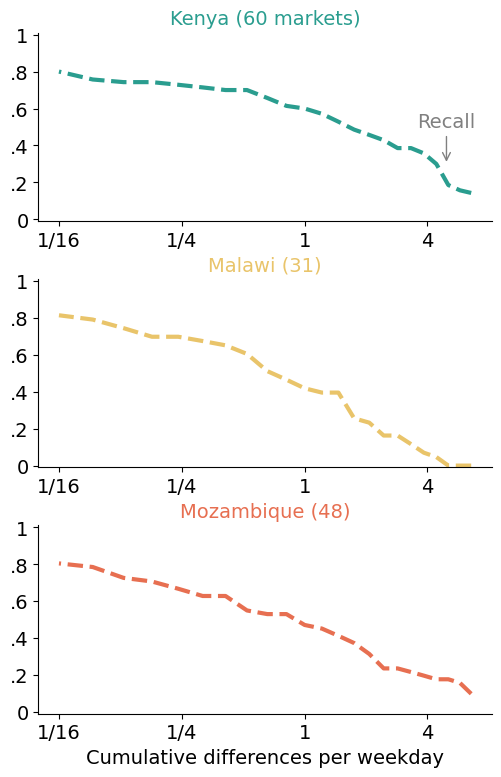

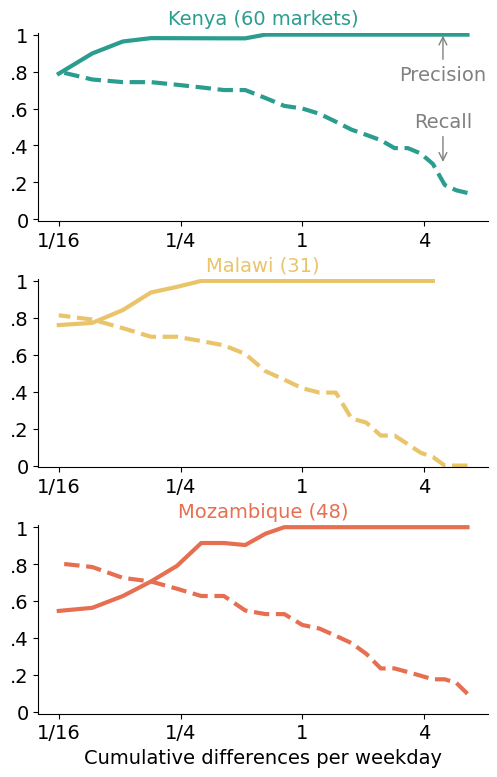

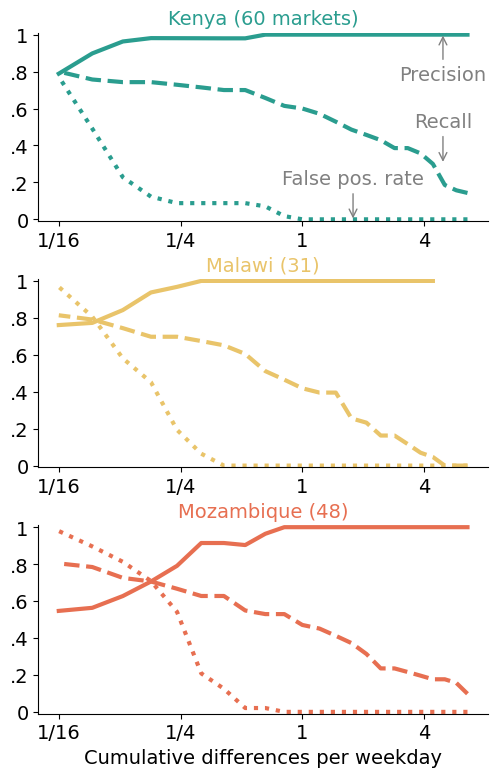

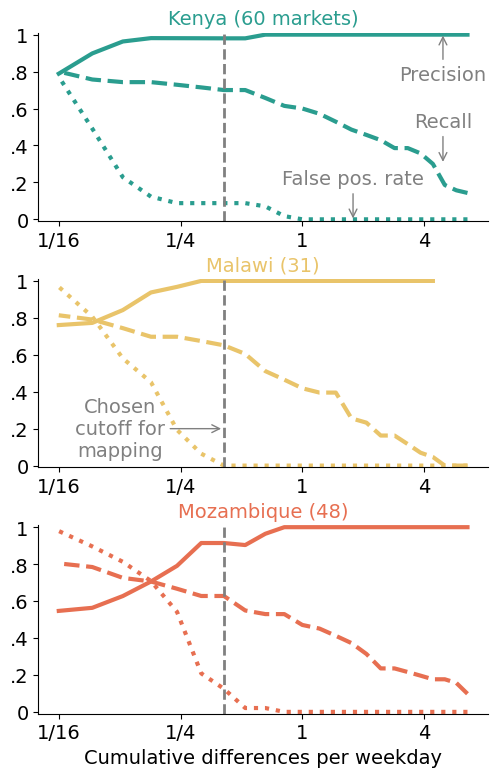

country  thres     valid  precision    recall       fpr  cutoffs_orig_log
56       Kenya     24  0.719298   0.980000  0.700000  0.087719         -0.892574
57      Malawi     24  0.709677   1.000000  0.651163  0.000000         -0.892574
58  Mozambique     24  0.645833   0.914286  0.627451  0.125000         -0.892574

country
Kenya         0.771930
Malawi        0.774194
Mozambique    0.645833
Name: valid, dtype: float64

In [36]:
# Create list of detected days for various threshold levels

freqDayStr_short='w7'
maxRank = 4 # exclude altitude levels above this
ring_area_share = 0.8  # Only consider rings whose area is more than 100(1-X)% of the shape defining the outer border of the ring

prefix = "exports-mai2023"
varsOfInterest=['p50','sumsum', 'ccount']
threshold_for_market=24
bucket=client.get_bucket('exports-mai2023')

forMerge=['ident','weekdayThisAreaIsActive','date','mktDay','mktID','locGroup','time','year','month', 'weekday', 'mkt_lat','mkt_lon','time_decimal'] 
patterns_to_drop = ['ground_control','strictnessRank', 'subStrictnessRank''Geography','origName_', 'coorLength_', '.geo', 'system:index_b0', 'system:index', 'weekday_','market']
propToDrop=['quality_category','system:index', '.geo','order_id', 'pixel_resolution','gsd','provider', 'published', 'publishing_stage', 'item_type', 'item_id', 'snow_ice_percent', 'strip_id','updated']

list_df_acrossLocs = []
pd.set_option('display.width', 100)  # Set display width
pd.set_option('display.max_columns', 500)  # Show all columns

df1 = pd.read_csv('forFigures/malawi_validationMarkets.csv')
df1['country'] = 'Malawi'
df1.loc[df1['loc'] == 'lon35_0148lat-16_2', 'weekdays'] = "2,6" # based on visual inspection
df1.loc[df1['loc'] == 'lon35_3223lat-15_6801', 'weekdays'] = "3,0,6" 
df1.loc[df1['loc'] == 'lon34_8547lat-15_4476', 'weekdays'] = "2,6" 

df2 = pd.read_csv('forFigures/kenya_validationMarkets.csv')
df2['country'] = 'Kenya'
df2.loc[df2['loc'] == 'lon1_0312lat34_9975', 'weekdays'] = "2,0" # based on visual inspection
df2.loc[df2['loc'] == 'lon0_4892lat34_8373', 'weekdays'] = "1" 

df3 = pd.read_csv('forFigures/mozambique_validationMarkets.csv')
df3['country'] = 'Mozambique'
remove= ['lon40_6945lat-14_8443','lon39_5196lat-14_0691', 'lon40_5215lat-14_3051'] # only opened in 2023
df3.loc[df3['loc'] == 'lon39_2759lat-15_1246', 'weekdays'] = '0' # based on visual inspection
df3.loc[df3['loc'] == 'lon38_0526lat-16_9714', 'weekdays'] = '2'
df3.loc[df3['loc'] == 'lon39_1221lat-15_0092', 'weekdays'] = '0'
df3 = df3[~df3['loc'].isin(remove)].reset_index(drop=True)

df_validation = pd.concat([df1, df2,df3], ignore_index=True)
df_validation = df_validation[['loc', 'country', 'weekdays']]
df_validation = df_validation.dropna(subset=['weekdays'])
df_validation = df_validation.dropna(subset=['loc']).reset_index(drop=True)
df_validation['weekdays'] = df_validation['weekdays'].str.replace(' ', ',')
df_validation['weekdays'] = df_validation['weekdays'].str.replace(',,', ',')

#print(len(df_validation[df_validation['country']=='Malawi']['loc'].unique()))

locs = df_validation['loc'].unique()

## no exports because no shape detected with pipeline
no_shapes = ["lon-0_3438lat34_8801",'lon0_3355lat34_6492','lon0_5214lat34_7107']
no_shapes_simul = ['lon0_2067lat34_4904','lon0_1971lat34_6969','lon0_3355lat34_6492','lon39_1221lat-15_0092',
                   'lon0_4413lat34_7168','lon35_6374lat-15_8082','lon0_7281lat34_8767','lon0_6563lat34_5907',
                   'lon0_6511lat34_8766','lon0_604lat34_8756','lon0_5364lat34_4999','lon0_4845lat34_7496',
                   'lon0_471lat34_315','lon0_4218lat34_4254','lon0_3816lat34_5842','lon0_3606lat34_4016'
                  ]
# no export because "Computation timed out error" 
no_03export=['lon35_4511lat-14_362','a']

def check_file_exists(bucket, file_path):
    """Check if a file exists in a Google Cloud Storage bucket."""
    blob = bucket.blob(file_path)
    return blob.exists()
results_df = pd.DataFrame(columns=['loc', 'thres','detected_days','detected_days_simul'])
results_df = results_df.astype('object')
locsProb=['']
locCount=0

for exportType in ['Act5','Actval']:
    for loc in sorted(locs, reverse=True):
        #print('loc', loc)
        locCount=locCount+1
        # Get the GEEbucket and locGroup for the current location
        try:
            GEEbucket = checkLocationFileStatus(loc, 'bucket')
            locGroup = checkLocationFileStatus(loc, 'locGroup')
        except:
            continue

        # Read the activity CSV file
        if exportType=='Act5' and (loc in no_shapes or loc in no_03export): 
            for t in range(8,31):
                temp_df = pd.DataFrame({'loc': [loc], 'thres': [t], 'detected_days': [[]]})
                results_df = pd.concat([results_df, temp_df], ignore_index=True)
        elif exportType=='Actval' and (loc in no_shapes_simul):
            for t in range(8,31):
                results_df.loc[(results_df['loc'] == loc) & (results_df['thres'] == t), 'detected_days_simul'] = ''
        else:
            if loc == "lon0_8314lat35_0888":
                df = pd.read_csv(f'gs://exports-mai2023/Kenya/measures/exportActval_maxpMaxlon0_8305lat35_0898_w7.csv')
            else:
                df = pd.read_csv(f'gs://exports-mai2023/{locGroup}/measures/export{exportType}_maxpMax{loc}_{freqDayStr_short}.csv')

            # keep only entries that fall between the strictest rank we define and the least strict one for a given shape, but at least 30
            minRank = max(df['strictnessRank'].min(),30)
            df = df[(df['strictnessRank'] <= minRank) & (df['strictnessRank'] >= maxRank)]
            df = df[((df['subStrictnessRank'] <= minRank) & (df['subStrictnessRank'] > maxRank)) | (pd.isna(df['subStrictnessRank'])) | (df['subStrictnessRank'] ==100) ]

            df['subStrictnessRank'] = df['subStrictnessRank'].fillna(100).astype(int)

            eligible_rings = df[df['subStrictnessRank'] != 100].groupby('strictnessRank', as_index=False)['subStrictnessRank'].max()
            additional_rows = pd.DataFrame({
                'strictnessRank': df['strictnessRank'].unique(),
                'subStrictnessRank': 100
            })
            eligible_shapes = pd.concat([eligible_rings, additional_rows]).sort_values(by='strictnessRank').reset_index(drop=True)

            df_elig =  pd.merge(df, eligible_shapes, on=['strictnessRank', 'subStrictnessRank'])

            df_elig.rename(columns={'weekdayShp': 'weekdayThisAreaIsActive'}, inplace=True)

            # Extract image id 
            df_elig['ident'] = df_elig['ident'].str.rsplit('_maxpMax', n=1).str[0].str[1:] 
            df_elig['weekdayThisAreaIsActive'] = df_elig['weekdayThisAreaIsActive'].astype(int)
            df_elig['strictnessRank'] = df_elig['strictnessRank'].astype(int)

            # Create area_id column from the strictnessRank variables
            df_elig['strictnessRank_str'] = df_elig['strictnessRank'].apply(prepend_zero_if_single_digit)
            df_elig['subStrictnessRank_str'] = df_elig['subStrictnessRank'].apply(prepend_zero_if_single_digit)
            df_elig['area_id'] = df_elig['strictnessRank_str'].astype(str) + '_' + df_elig['subStrictnessRank_str'].astype(str)

            geos = df_elig['area_id'].unique()

            # Append area id to variable names
            new_column_names = {old_col: old_col + '_maxpMax'  for old_col in varsOfInterest}
            df_elig = df_elig.rename(columns=new_column_names)

            # Assign info variables
            df_elig = infoVars(df_elig, loc, locGroup)
            # Identify market days
            if exportType=="Act5": 
                for t in range(8,31):
                    df_elig, localMktDays = identifyMktDays_validation(df_elig,minRank, t)
                    strings = [str(number) for number in localMktDays]
                    temp_df = pd.DataFrame({'loc': [loc], 'thres': [t], 'detected_days': [strings]})
                    results_df = pd.concat([results_df, temp_df], ignore_index=True)
            if exportType=="Actval":
                for t in range(8,31):
                    df_elig, localMktDays = identifyMktDays_validation(df_elig,minRank, t)
                    strings = [str(number) for number in localMktDays]
                    results_df.loc[(results_df['loc'] == loc) & (results_df['thres'] == t), 'detected_days_simul'] = ','.join(map(str, strings))

def safe_convert(s):
    # Split the string by commas and filter out any empty strings
    return [int(x) for x in s.split(',') if x.isdigit()]
results_df['detected_days_simul'].fillna('', inplace=True)
results_df['detected_days_simul'] = results_df['detected_days_simul'].apply(safe_convert)
print(locsProb)

df_merged = pd.merge(results_df, df_validation, on='loc', how='outer')

# for each detected day value, set 1 if in actual day list, 0 otherwise
def convert_string_to_list(s):
    # Handle cases where the input might not be a string
    if not isinstance(s, str):
        return []

    # Replace commas with spaces and split by spaces
    items = s.replace(',', ' ').split()
    
    # Strip spaces and convert to strings
    return [x.strip() for x in items if x.strip()]
    
def check_all_substrings(row):
    if row['detected_days']:  # Check if varA is not empty
        if row['detected_days'] and isinstance(row['detected_days'], list):
            return int(all(day in row['weekdays'] for day in row['detected_days']))
    return 0  # Return 0 if varA is empty
df_merged['weekdays'] = df_merged['weekdays'].apply(convert_string_to_list)
df_merged['detected_days'] = df_merged['detected_days'].apply(lambda x: x if isinstance(x, list) else [])
# Apply the function to each row and create a new column
df_merged['valid'] = df_merged.apply(check_all_substrings, axis=1)
#df_merged['weekdays'] = df_merged['weekdays'].apply(lambda x: x if isinstance(x, list) else [])
#with pd.option_context('display.max_rows', None):
    #display(df_merged)

def precision(a_list, b_list):
    return [1 if item in b_list else 0 for item in a_list]

def recall(a_list, b_list):
    return [1 if item in b_list else 0 for item in a_list]

def fpr(a_list):
    if a_list:
        return 1
    else:
        return 0
    
df_merged['precision'] = df_merged.apply(lambda row: precision(row['detected_days'], row['weekdays']), axis=1)
df_merged['recall'] = df_merged.apply(lambda row: precision(row['weekdays'],row['detected_days']), axis=1)
df_merged['fpr'] = df_merged.apply(lambda row: fpr(row['detected_days_simul']), axis=1)
#with pd.option_context('display.max_rows', None):
    #display(df_merged)
print(len(df_merged[df_merged['country']=='Kenya']['loc'].unique()))
print(len(df_merged[df_merged['country']=='Malawi']['loc'].unique()))
print(len(df_merged[df_merged['country']=='Mozambique']['loc'].unique()))

def mean_of_lists(series):
    # Flatten all lists in the series
    all_items = [item for sublist in series for item in sublist]
    # Return the mean of all items or NaN if the list is empty
    return np.mean(all_items) if all_items else np.nan

# Group by 'varA' and apply the function to 'varB'
collapse_by=['country','thres']
prec = df_merged.groupby(collapse_by)['precision'].apply(mean_of_lists).reset_index()
#display(prec)
rec = df_merged.groupby(collapse_by)['recall'].apply(mean_of_lists).reset_index()
#display(rec)
df_merge1 = pd.merge(prec, rec, on=collapse_by, how='outer')

df_collapsed = df_merged.groupby(collapse_by)['valid'].mean().reset_index()
df_collapsed = pd.merge(df_collapsed, df_merge1, on=collapse_by, how='outer')
df_collapsed1 = df_merged.groupby(collapse_by)['fpr'].mean().reset_index()
df_collapsed = pd.merge(df_collapsed, df_collapsed1, on=collapse_by, how='outer')

thres_range = np.sort(np.power(np.arange(2, -0.05, -0.05),4))[::-1]
df_values = pd.DataFrame({
    'thres': range(len(thres_range)),  # Index as a column
    'cutoffs_orig_log': np.log(thres_range)                # Log-transformed values as a column
})
#with pd.option_context('display.max_rows', None):
    #display(df_values)

df_collapsed = pd.merge(df_collapsed, df_values, on='thres', how='outer')
#with pd.option_context('display.max_rows', None):
    #display(df_collapsed)
fontsize=14


## LEFT top panels ##
titles =['Kenya', 'Malawi', 'Mozambique']

subtitles =[f" ({len(df_merged[df_merged['country']=='Kenya']['loc'].unique())} markets)",
            f" ({len(df_merged[df_merged['country']=='Malawi']['loc'].unique())})",
            f" ({len(df_merged[df_merged['country']=='Mozambique']['loc'].unique())})"]
print(titles, subtitles)
lp_prec = 'solid' 
lp_rec = 'dashed'
lp_acc = 'dotted'
for build in range(0,4):
    fig = plt.figure(figsize=(13/2.54, 20/2.54))  # Convert from cm to inches

    # Define grid specification with adjusted height ratios
    gs = GridSpec(1, 1, width_ratios=[1])  # 1 rows, 2 columns
    left_ax = fig.add_subplot(gs[0, 0])  # Left portion
    gap = 0.085
    for spine in ['top', 'right', 'bottom', 'left']:
        left_ax.spines[spine].set_visible(False)
    left_ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 

    left_topleft_ax = left_ax.inset_axes([0,   2*(1-2*gap)/3+2*gap, 1, (1-2*gap)/3]) 
    left_topmiddle_ax = left_ax.inset_axes([0, (1-2*gap)/3+gap, 1, (1-2*gap)/3]) 
    left_topright_ax = left_ax.inset_axes([0,   0, 1, (1-2*gap)/3])
    axes = [left_topleft_ax,left_topmiddle_ax,left_topright_ax]

    gap = 0.075

    for p in range(0,3):
        axes[p].annotate(titles[p]+subtitles[p],  ha='center', va='bottom', fontsize=fontsize, xy=(.5, 1.025), xycoords='axes fraction', color=maincolors[p])
        df = df_collapsed[df_collapsed['country'] == titles[p]]
        axes[p].plot(df['cutoffs_orig_log'], df['recall'], linestyle=lp_rec, color=maincolors[p], label='Recall',linewidth=3)
        if build>0:
            axes[p].plot(df['cutoffs_orig_log'], df['precision'], linestyle=lp_prec, color=maincolors[p], label='Precision',linewidth=3)
        if build>1:
            axes[p].plot(df['cutoffs_orig_log'], df['fpr'], linestyle=lp_acc, color=maincolors[p], label='False pos. rate',linewidth=3)
        for spine in ['top', 'right']:
            axes[p].spines[spine].set_visible(False)
        axes[p].set_yticks([0,0.2,0.4,0.6,0.8,1])
        axes[p].set_yticklabels(["0",".2",".4",".6",".8","1"])
        ticks = [1/16, 1/4, 1, 4]
        ticks_str = ["1/16"  , "1/4", "1", "4"]
        axes[p].set_xticks(np.log(ticks), ticks_str)

        axes[p].set_ylim(-0.01, 1.01)  # Set x-axis limits from 1 to 4
        axes[p].tick_params(labelsize=fontsize)
        if build>2:
            axes[p].axvline(df_values.loc[df_values['thres'] == 24, 'cutoffs_orig_log'].iloc[0], color='gray', linestyle='--', linewidth=2, label='')

    axes[2].set_xlabel('Cumulative differences per weekday',fontsize=fontsize)
    left_ax.tick_params(left = False, right = False, labelleft = False, labelbottom = False, bottom = False) 
    axes[0].annotate('Recall',  xycoords='axes fraction',xy=(.9, 0.3), xytext=(.9, .5), arrowprops=dict(arrowstyle='->', color='gray'), fontsize=fontsize, color='gray',ha='center')
    if build>0:
        axes[0].annotate('Precision', xycoords='axes fraction', xy=(.9, 1), xytext=(.9, .75), arrowprops=dict(arrowstyle='->', color='gray'), fontsize=fontsize, color='gray',ha='center')
    if build>1:     
        axes[0].annotate('False pos. rate', xycoords='axes fraction', xy=(0.7, 0), xytext=(.7, .175), arrowprops=dict(arrowstyle='->', color='gray'), fontsize=fontsize, color='gray',ha='center', va='bottom')
    if build>2:
        axes[1].annotate('Chosen\ncutoff for\nmapping', xy=(np.log(0.40959999999999963), 0.2), xytext=(np.log(1/8), 0.2), arrowprops=dict(arrowstyle='->', color='gray'), fontsize=fontsize, color='gray',ha='center', va='center')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.savefig(f"forFigures/Figure2_{build}.png", transparent=True, bbox_inches='tight', pad_inches=0, dpi=300)    
    plt.show()

    plt.close(fig)
    fig.clf()

display(df_collapsed[df_collapsed['thres'] == 24])
display(df_collapsed.groupby('country')['valid'].max())

## Figure 3

Parameters

In [ ]:
# Target scale (1km) for population density maps
tgtScale = 1000
# Target scale (1km) for gridcells. May need to be exported as an asset
tgtScale2 = 1000

# limits for pop-density in map
limits = [0, 100, 250, 500, 1000, 100000]
limit_labels = ["<100", "<250", "<500", "<1,000", ">1,000"]

country = "Ethiopia"
country_short = "ETH"

# Colors for map
color1 = "#e9c56a"
color2 = "#2A9D8F"
color3 = "#e76f51"

# Generate 5 evenly spaced colors between white and black
colors = [mcolors.to_hex((v, v, v)) for v in np.linspace(1, 0, len(limits) - 1)]

# Length of scale bar at specific latitude
latitude = 10  # Example latitude (in degrees)
km = 100  # Distance in kilometers (100 km)


Shared inputs across subfigures

In [37]:
eth_boundaries_shp = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(
    ee.Filter.eq("country_na", country)
) 

worldpop = ee.Image(ee.ImageCollection("JRC/GHSL/P2023A/GHS_POP").filterDate('2020-01-01','2021-01-01').first()).clip(eth_boundaries_shp)
worldpop = worldpop.set('system:footprint', eth_boundaries_shp.geometry())
worldpop_scale = 100
addis =ee.FeatureCollection("projects/ethiopia-candidate-locs/assets/cityMask").first().geometry()
worldpop_without_addis = worldpop.clip(eth_boundaries_shp.geometry().difference(addis))

eth_boundaries = geemap.ee_to_geojson(
    eth_boundaries_shp
)  # Export the asset to a GeoJSON file
eth_boundaries = json.dumps(eth_boundaries)  # Convert back to string
eth_boundaries = StringIO(eth_boundaries)  # Create file-like object
eth_boundaries = gpd.read_file(
    eth_boundaries
)  # Load the GeoJSON file into a GeoDataFrame

pop_addis = worldpop.reduceRegion(
  geometry = ee.FeatureCollection("projects/ethiopia-candidate-locs/assets/cityMask").first().geometry(),
  reducer = ee.Reducer.sum(),
  scale = worldpop.projection().nominalScale()
).get('population_count').getInfo()
print('pop_addis', pop_addis)


pop_addis 5656675.60219059


FIGURE 3A

Load and process a population density map   

In [38]:
# Compute the scale adjustment factor
factor = ee.Number(worldpop_scale).pow(2).divide(ee.Number(tgtScale).pow(2))

# Rescale to 1km resolution
worldpop_1km = (
    worldpop.divide(factor)
    .reduceResolution(reducer=ee.Reducer.mean(), bestEffort=True)
    .reproject(crs=worldpop.projection(), scale=tgtScale)
)
#Map = geemap.Map()
#Map.addLayer(worldpop_1km.gt(0).And(worldpop_1km.lt(100)).selfMask())
#Map.centerObject(worldpop)
#Map

In [39]:
# Generate binary masks and export each to a GeoTIFF
for i in range(len(limits) - 1):
    print(f"between {limits[i]} and {limits[i + 1]}")
    mask = worldpop_1km.gte(limits[i]).And(worldpop_1km.lt(limits[i + 1])).selfMask()
    try:
        geemap.ee_to_geotiff(
            mask,
            f"temp/im{i}.tif",
            resolution=tgtScale,
            crs="EPSG:4326",
            quiet=True,
            to_cog=False,
            bbox= [32,-2,52,15]
        )
    except Exception as e:
        if "Permission denied" in str(e):
            print(
                f"Permission denied for file: im{i}.tif (verify whether created anyway)"
            )
        else:
            print(e)
            stop


between 0 and 100
between 100 and 250
between 250 and 500
between 500 and 1000
between 1000 and 100000


Load latest set of detected marketplaces


In [40]:
query = f"""
       SELECT marketLat, marketLon FROM `mai-database`.`location_file` lf
        WHERE to_delete IS NULL
        AND 00DownStatus IN ("complete","updating")
        AND country="{country}"
        AND (false_positive IN (-1,0) OR false_positive IS NULL)
        AND EXISTS(
            SELECT 1 FROM process_runs pr2
            WHERE pr2.Location=lf.Location
            AND Setup="MpM6"
            AND Status="complete"
        )
        AND NOT EXISTS(
            SELECT 1 FROM process_runs pr
            WHERE pr.Location=lf.Location
            AND Setup="MpM6" 
            AND runAnyway="no"
        )
        """

def create_gdf_from_markets(df):
    """Convert a DataFrame with 'marketLat' and 'marketLon' into a GeoDataFrame."""
    df["geometry"] = df.apply(
        lambda row: Point(row["marketLon"], row["marketLat"]), axis=1
    )
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  # Assuming WGS84


def shpFromQuery(query):
    df = pd.read_sql(query, engine)
    df = df[df["marketLat"].notnull()]
    gdf = create_gdf_from_markets(df)
    print("# markets:", len(gdf))
    return gdf


market_centroids = shpFromQuery(query)
display(market_centroids)

# markets: 1710


marketLat  marketLon                   geometry
0     10.007357  38.244288  POINT (38.24429 10.00736)
1     10.008338  38.888313  POINT (38.88831 10.00834)
2     10.022000  39.250403     POINT (39.2504 10.022)
3     10.058492  38.991790  POINT (38.99179 10.05849)
4     10.121568  39.658728  POINT (39.65873 10.12157)
...         ...        ...                        ...
3003   9.891914  39.145057   POINT (39.14506 9.89191)
3004   9.911862  40.015798    POINT (40.0158 9.91186)
3005   9.913064  38.520127   POINT (38.52013 9.91306)
3006   9.959688  36.862882   POINT (36.86288 9.95969)
3007  10.000771  39.902311  POINT (39.90231 10.00077)

[1710 rows x 3 columns]

Calculate length of scalebar for map   

In [41]:
def longitude_degrees_for_km(latitude, km):
    # Convert latitude to radians
    latitude_rad = math.radians(latitude)

    # Distance of 1 degree of longitude in kilometers at the given latitude
    distance_per_degree = 111.32 * math.cos(latitude_rad)

    # Calculate the number of degrees of longitude that correspond to the given km
    longitude_degrees = km / distance_per_degree
    return longitude_degrees


longitude_degrees = longitude_degrees_for_km(latitude, km)
print(
    f"{km} km corresponds to {longitude_degrees:.6f} degrees of longitude at latitude {latitude}°."
)


100 km corresponds to 0.912169 degrees of longitude at latitude 10°.


Function to plot the population density map

In [42]:
def plot_raster_with_crs(im, ax, cmap=ListedColormap(["white", "blue"])):
    filename = f"temp/im{im}.tif"
    with rasterio.open(filename) as src:
        # Read the raster data (first band)
        raster_data = src.read(1)

        # Get the raster transform and CRS
        transform_matrix = src.transform
        original_crs = src.crs  # Get original CRS
        target_crs = "EPSG:4326"  # Define target CRS

        # Get raster dimensions
        height, width = raster_data.shape

        # Create row and column indices
        rows, cols = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")

        # Convert row/col indices to spatial coordinates in the original CRS
        x, y = rasterio.transform.xy(transform_matrix, rows, cols)

        # Convert to numpy arrays
        x = np.array(x)
        y = np.array(y)

        # Reproject coordinates to EPSG:4326 if necessary
        if original_crs != target_crs:
            lon, lat = transform(original_crs, target_crs, x.flatten(), y.flatten())
            lon = np.array(lon).reshape(x.shape)
            lat = np.array(lat).reshape(y.shape)
        else:
            lon, lat = x, y  # If already in EPSG:4326, use as is

        # Get extent in EPSG:4326
        min_lon, max_lon = lon.min(), lon.max()
        min_lat, max_lat = lat.min(), lat.max()

        # Plot the raster data with proper extent
        ax.imshow(
            raster_data,
            cmap=cmap,
            interpolation="none",
            extent=(min_lon, max_lon, min_lat, max_lat),
        )


Put everything in a plot

In [44]:
# )  # Create a figure with size 16x16 inches
def plot_population_and_markets(ax, one, two):
    # Read the raster data
    for im in range(0, 5):
        plot_raster_with_crs(im, ax, cmap=ListedColormap(["none", colors[im]]))

    # Plot the market centroids (assuming market_centroids is already a GeoDataFrame with the 'geometry' column)
    market_centroids.plot(
        ax=ax, facecolor="none", edgecolor=color3, marker="o", markersize=12, label="Detected marketplaces", alpha=1
    )

    # Plot the Ethiopia boundaries
    eth_boundaries.plot(ax=ax, color="none", edgecolor="black", linewidth=1)

    legend_patches = [
        mpatches.Patch(
            facecolor=colors[i],
            label=limit_labels[i],
            edgecolor="black",
            linewidth=0.5,
        )
        for i in range(len(limits) - 1)
    ]

    legend_title = mpatches.Patch(
        facecolor='none',  # Transparent fill
        edgecolor='none',  # No border
        label="People per km²:"  # Leading spaces to align
    )

    market_legend = mlines.Line2D(
        [],
        [],
        color=color3,
        markerfacecolor="none",
        linestyle="none",
        markeredgecolor=color3,
        marker="o",
        markersize=7,
        label="Detected marketplaces",
    )

    #legend_patches = [legend_title] + legend_patches    
    
    leg = ax.legend(
        handles=legend_patches,
        loc="upper left",
        frameon=False,
        bbox_to_anchor=(.75, .97),
        borderaxespad=0,
    )
    leg.set_title("\n  People per km²:", prop={"size": 10})
    ax.add_artist(leg)
    #leg.get_title().set_multialignment("center")
    
    legend1 = ax.legend(handles=[market_legend], loc='upper left', frameon=False, bbox_to_anchor=(0.75, 1), borderaxespad=0)
    ax.add_artist(legend1)

    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(
        ax.transData,
        longitude_degrees,
        f"{km} km",
        "lower left",
        pad=0,
        color="black",
        frameon=False,
        size_vertical=0.05,
        fontproperties=fontprops,
    )
    scalebar.set_bbox_to_anchor((one, two), transform=ax.transAxes)
    ax.add_artist(scalebar)

    # Set the minimum limit for the y-axis to this latitude and an arbitrary max limit
    ax.set_ylim(bottom=eth_boundaries.total_bounds[1], top=eth_boundaries.total_bounds[3])
    ax.set_xlim(left=eth_boundaries.total_bounds[0], right=eth_boundaries.total_bounds[2])

    # Add labels and display the map
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis("off")
    ax.text(
        -0,
        1,
        "A",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        verticalalignment="top",
        horizontalalignment="left",
    )
    #plt.show()

FIGURE 3B

In [45]:
## concentric rings around marketplaces
geo = eth_boundaries_shp.first().geometry(5)

market_centroids = market_centroids#.to_crs(epsg=32637)
markets_fc = geemap.geopandas_to_ee(market_centroids)#.limit(500)
rings = ee.FeatureCollection(ee.List([1000, 2000, 5000,10000,20000]).map(
    lambda r: markets_fc
             .map(lambda m: ee.Feature(m.buffer(r).simplify(ee.Number(r).divide(2)).intersection(geo,ee.Number(r).divide(2))))
             .union(ee.Number(r).divide(2)).first().set('radius',r))).map(
        lambda f: ee.Feature(f).set('area_km2', ee.Feature(f).area().divide(1e6))
    )#.merge(ee.FeatureCollection(ee.Feature(geo).set('radius',999999, 'area_km2',geo.area().divide(1e6))))
             
print(rings.aggregate_mean('radius').getInfo())
print(rings.aggregate_min('area_km2').getInfo(),rings.aggregate_mean('area_km2').getInfo(),rings.aggregate_max('area_km2').getInfo() )


7600
4382.970140252884 180094.84073272737 488178.36728060164


In [46]:
grid_w_pop = (
    worldpop.reduceRegions(
        collection = rings, #grid.randomColumn().limit(5,'random'), #.sort('random')
        reducer = ee.Reducer.sum(),
        scale = worldpop.projection().nominalScale(),
        tileScale = 16,
    ).select(["sum", "area_km2","radius"], ["population", "area_km2","radius"])
)

task = ee.batch.Export.table.toAsset(
    collection=grid_w_pop,
    description='export_grid_w_pop',
    assetId = "projects/planetupload/assets/cleanedLocs/"+country+"_ringsghsl"
)

# Start the task
task.start()

grid_w_pop_without_addis = (
    worldpop_without_addis.reduceRegions(
        collection = rings, #grid.randomColumn().limit(5,'random'), #.sort('random')
        reducer = ee.Reducer.sum(),
        scale = worldpop.projection().nominalScale(),
        tileScale = 16,
    ).select(["sum", "area_km2","radius"], ["population", "area_km2","radius"])
)

task = ee.batch.Export.table.toAsset(
    collection=grid_w_pop_without_addis,
    description='export_grid_w_pop',
    assetId = "projects/planetupload/assets/cleanedLocs/"+country+"_ringsghsl_withoutaddis"
)

# Start the task
task.start()

In [47]:
grid_w_pop = ee.FeatureCollection(
    f"projects/planetupload/assets/cleanedLocs/{country}_ringsghsl"
)
print(grid_w_pop.aggregate_mean("population").getInfo(), grid_w_pop.size().getInfo())
grid_w_pop_without_addis = ee.FeatureCollection(
    f"projects/planetupload/assets/cleanedLocs/{country}_ringsghsl_withoutaddis"
)
print(grid_w_pop_without_addis.aggregate_mean("population").getInfo(), grid_w_pop_without_addis.size().getInfo())


64064088.79270632 6
62380984.392618395 6


In [48]:
df_b = geemap.ee_to_gdf(grid_w_pop)
df_b_noaddis = geemap.ee_to_gdf(grid_w_pop_without_addis)
df_b = df_b.merge(df_b_noaddis[['radius','population']], on='radius', suffixes=('', '_noaddis'))
print("done")
display(df_b)
display(df_b_noaddis)

done


geometry       area_km2    population  radius  \
0  MULTIPOLYGON (((34.35083 10.5693, 34.35808 10....    4386.414758  1.973385e+07    1000   
1  MULTIPOLYGON (((34.34259 10.56538, 34.35708 10...   17371.443269  2.971100e+07    2000   
2  MULTIPOLYGON (((34.31788 10.55362, 34.35408 10...  102071.686456  4.796744e+07    5000   
3  MULTIPOLYGON (((34.28025 10.53863, 34.28273 10...  288665.928635  7.559220e+07   10000   
4  MULTIPOLYGON (((34.27611 9.29432, 34.42037 9.1...  488178.367281  1.010961e+08   20000   
5  MULTIPOLYGON (((34.10197 9.55673, 34.10444 9.5...  701698.125919  1.102839e+08   50000   

   population_noaddis  
0        1.973385e+07  
1        2.971100e+07  
2        4.795777e+07  
3        7.537286e+07  
4        9.688319e+07  
5        1.046272e+08

geometry       area_km2    population  radius
0  MULTIPOLYGON (((34.35083 10.5693, 34.35808 10....    4386.414758  1.973385e+07    1000
1  MULTIPOLYGON (((34.34259 10.56538, 34.35708 10...   17371.443269  2.971100e+07    2000
2  MULTIPOLYGON (((34.31788 10.55362, 34.35408 10...  102071.686456  4.795777e+07    5000
3  MULTIPOLYGON (((34.28025 10.53863, 34.28273 10...  288665.928635  7.537286e+07   10000
4  MULTIPOLYGON (((34.27611 9.29432, 34.42037 9.1...  488178.367281  9.688319e+07   20000
5  MULTIPOLYGON (((34.10197 9.55673, 34.10444 9.5...  701698.125919  1.046272e+08   50000

In [49]:
def pop_share_plot(ax):


    # Sort the dataframe by 'distance_to_market'
    #df_bb = df_b.sort_values(by='nearest_mkt_km')
    df_bb = df_b.sort_values(by='radius')
    df_bb['radius_km'] = df_bb['radius']/1000
    # Calculate the total population and area
    total_population = 109628500 # https://www.portal.worldpop.org/ df_b[df_b['radius']=999999]["population"] #df_bb['population'].sum()
    total_population_noaddis = 103971800 # https://www.portal.worldpop.org/ df_b[df_b['radius']=999999]["population"] #df_bb['population'].sum()
    total_area = 1133384 # df_b[df_b['radius']=999999]["area_km2"]

    # Calculate the cumulative sum of population and area
    df_bb['cumulative_population'] = df_bb['population'].cumsum()
    df_bb['cumulative_area'] = df_bb['area_km2'].cumsum()

    # Calculate the cumulative share of population and area
    df_bb['population_share'] = 100 * df_bb['population'] / total_population
    df_bb['population_share_noaddis'] = 100 * df_bb['population_noaddis'] / total_population_noaddis
    df_bb['area_share'] = 100 * df_bb['area_km2'] / total_area

    # Optional: if you want to only keep the relevant columns
    df_bb=df_bb[df_bb['radius']<50000]
    df_bb = df_bb[['radius_km', 'population_share', 'area_share','population_share_noaddis']]
    display(df_bb)

    df_bbb = df_bb #df_bb[df_bb['nearest_mkt_km'] < 50]


    #fig, ax = plt.subplots(figsize=(8, 6))
    x_vals = range(len(df_bbb))  # Even spacing by row
    def format_label(x):
        return str(int(x)) if x == int(x) else f"{x:.1f}"

    labels = df_bbb['radius_km'].map(format_label)

    # Plot the data
    ax.bar(x_vals, df_bbb['population_share_noaddis'], label='Population excl. Addis Ababa',color="none", edgecolor=color3, linewidth=1.25, linestyle='--')
    ax.bar(x_vals, df_bbb['population_share'], label='Population',color="none", edgecolor=color3, linewidth=1.25)
    ax.bar([x + 0 for x in x_vals], df_bbb['area_share'], label='Area',color="none",edgecolor=colors[2], linewidth=1.25, width=0.5 )
    ax.set_xticks(x_vals)
    ax.set_xticklabels(labels)
    # Set labels and title
    ax.set_xlabel('Distance from nearest detected marketplace (km)')
    ax.set_ylabel('Share within given distance')
    ax.set_title('')

    # Add a legend and grid
    ax.legend(frameon=False)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Add text
    ax.text(
        -0.15,
        1,
        "B",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        verticalalignment="top",
        horizontalalignment="left",
    )

    # Show the plot
    #plt.show()


Figure 3C

In [50]:
query = f'''
    SELECT date, mktDay, Location FROM activity_market am
    WHERE date>'2017-07-01' AND date<='2024-12-31'
    AND EXISTS(
        SELECT 1 FROM location_file lf
        WHERE lf.Location = am.Location
        AND country="{country}"
        AND (false_positive IN (-1,0) OR false_positive IS NULL)
    )
'''

df_c = pd.read_sql(query, engine)
df_c["month"] = df_c["date"].dt.month
df_c["year"] = df_c["date"].dt.year
#df_c["monthly_date"] = (df_c["date"].dt.year - 2016) * 12 + df_c["month"]
display(df_c)


date  mktDay              Location  month  year
0       2017-09-12       0  lon10_0047lat38_2509      9  2017
1       2017-09-16       1  lon10_0047lat38_2509      9  2017
2       2017-09-23       1  lon10_0047lat38_2509      9  2017
3       2017-09-28       0  lon10_0047lat38_2509      9  2017
4       2017-10-02       0  lon10_0047lat38_2509     10  2017
...            ...     ...                   ...    ...   ...
2469503 2023-09-24       0   lon9_9955lat39_8976      9  2023
2469504 2023-09-25       0   lon9_9955lat39_8976      9  2023
2469505 2023-09-25       0   lon9_9955lat39_8976      9  2023
2469506 2023-09-28       0   lon9_9955lat39_8976      9  2023
2469507 2023-09-28       0   lon9_9955lat39_8976      9  2023

[2469508 rows x 5 columns]

In [83]:
folder_path = r'forFigures/clouds_at_markets'  # Change this to your actual path
# from cloud_prob.ipynb
# Initialize list to store DataFrames
df_list = []

# Loop through files
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and filename.startswith("cloud_prob_"):
        # Extract year and month using regex
        match = re.search(r'cloud_prob_(\d{4})_(\d{2})\.csv', filename)
        if match:
            year = int(match.group(1))
            month = int(match.group(2))

            # Read the CSV
            file_path = os.path.join(folder_path, filename)
            #pd.read_csv(file_path)
            df = pd.read_csv(file_path, on_bad_lines="warn", engine="python", sep=None) #Paul's version

            # Add year and month columns
            df['year'] = year
            df['month'] = month

            # Append to list
            df_list.append(df)

# Concatenate all DataFrames
final_df = pd.concat(df_list, ignore_index=True)

# Optional: check result
print(final_df.head())

monthly_avg_cloud = final_df.groupby('month')['cloud_percentage'].mean().reset_index()

# Optional: sort by month
monthly_avg_cloud = monthly_avg_cloud.sort_values('month')

# Display result
print(monthly_avg_cloud)


                                            geometry              Location  cloud_percentage  \
0  POLYGON ((38.243821298527216 10.00734058407419...  lon10_0047lat38_2509         16.666667   
1  POLYGON ((38.887708431590994 10.00866223924842...  lon10_0114lat38_8886         33.333333   
2  POLYGON ((39.2502043633406 10.021870343161968,...   lon10_0194lat39_248         16.666667   
3  MULTIPOLYGON (((38.9904395757914 10.0591579662...  lon10_0568lat38_9943         16.666667   
4  POLYGON ((39.65767515624277 10.121012060837403...  lon10_1195lat39_6614         33.333333   

   total_images  year  month  
0             6  2019     12  
1             6  2019     12  
2             6  2019     12  
3             6  2019     12  
4             6  2019     12  
    month  cloud_percentage
0       1          9.293636
1       2         13.227547
2       3         17.573249
3       4         28.234791
4       5         28.074532
5       6         36.258093
6       7         61.342980
7       8    

In [74]:
from scipy.interpolate import make_interp_spline

def obs_per_month(ax):
    countsByMonthAndMkt = (
        df_c.groupby(["month","year", "Location"])["mktDay"].sum().reset_index()
    )

    # Avg. observations per month and market
    countsByMonth = (
        countsByMonthAndMkt.groupby(["month",'year'])["mktDay"].mean().reset_index()
    )
    #countsByMonth = countsByMonth[countsByMonth["year"] <= 2024 & countsByMonth["year"] >= 2017 ]
    years = sorted(countsByMonth["year"].unique())
    n_years = len(years)
    rgba_transparent = mcolors.to_rgba(color3, alpha=0.4)  # more transparent
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ['gray', color3], N=n_years)

    for i, year in enumerate(years):
        year_data = countsByMonth[countsByMonth["year"] == year]
        x = year_data["month"]
        y = year_data["mktDay"]

        # Interpolate to get a smooth curve
        x_new = np.linspace(x.min(), x.max(), 50)  # More points for a smooth curve
        spline = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
        y_smooth = spline(x_new)

        ax.plot(
            x_new,
            y_smooth,
            label=str(year),
            color=cmap(i / (n_years - 1)),
            linewidth=1.25
        )

    plt.xticks(ticks=range(1, 13), labels=[
        "Jan", "", "Mar", "", "May", "",
        "Jul", "", "Sep", "", "Nov", ""
    ])
    # Adding labels and title
    ax.set_ylabel("Mean # of market-day\nobs. per market & month")
    ax.set_xlabel("Month of year")
    ticks = [
        13,
        25,
        37,
        49,
        61,
        73,
        85,
        97,
    ]  # Months at which we want the labels (e.g., 1/2016, 1/2017, ...)
    labels = [
        "1/2017",
        "1/18",
        "1/19",
        "1/20",
        "1/21",
        "1/22",
        "1/23",
        "1/24",
    ]  # Corresponding labels

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_facecolor("none")
    ax.set_ylim(bottom=0)
    ax.set_xlim(0.5, 12.5)  # Ensures months 1–12 align center-wise
    ax.set_xticks(range(1, 13))
    ax.text(
        -0.15,
        1,
        "C",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        verticalalignment="top",
        horizontalalignment="left",
    )

    label_years = [2017, 2019, 2020, 2023,2024]

    for year in label_years:
        data = countsByMonth[(countsByMonth["year"] == year) & (countsByMonth["month"] == 12)]
        if not data.empty:
            x = data["month"].values[0]
            y = data["mktDay"].values[0]
            ax.text(
                x + 0.2, y,               # Slightly to the right of December
                str(year),
                color=cmap(years.index(year) / (n_years - 1)),  # Match line color
                fontsize=10,
                verticalalignment='center',
                horizontalalignment='left'
            )

 
def add_cloud_bar(ax4):
    # Compute mean cloud percentage by month

    # Plot bar chart
    ax4.bar(
        monthly_avg_cloud["month"],
        monthly_avg_cloud["cloud_percentage"],
        width=0.6,
        color='lightgray',
        alpha=0.8
    )
    
    max_cloud = monthly_avg_cloud["cloud_percentage"].max()
    max_rounded = np.ceil(max_cloud) 

    # Style and labels
    ax4.set_ylabel("Avg. cloud %", color='gray')
    #ax2.set_xlabel("Month of year")
    ax4.tick_params(axis='y', labelcolor='gray')
    ax4.set_ylim(0, 100)
    ax4.set_xlim(0.5, 12.5)
    ax4.set_xticks(range(1, 13))
    ax4.set_xticklabels([
        "Jan", "", "Mar", "", "May", "", "Jul", "", "Sep", "", "Nov", ""
    ])
    ax4.spines["top"].set_visible(False)
    ax4.spines["right"].set_visible(False)
    ax4.set_yticks([0, max_rounded])
    ax4.set_yticklabels([str(0), str(int(max_rounded))])

radius_km  population_share  area_share  population_share_noaddis
0        1.0         18.000659    0.387019                 18.980005
1        2.0         27.101527    1.532706                 28.576015
2        5.0         43.754534    9.005923                 46.125748
3       10.0         68.953059   25.469384                 72.493564
4       20.0         92.216992   43.072636                 93.182182

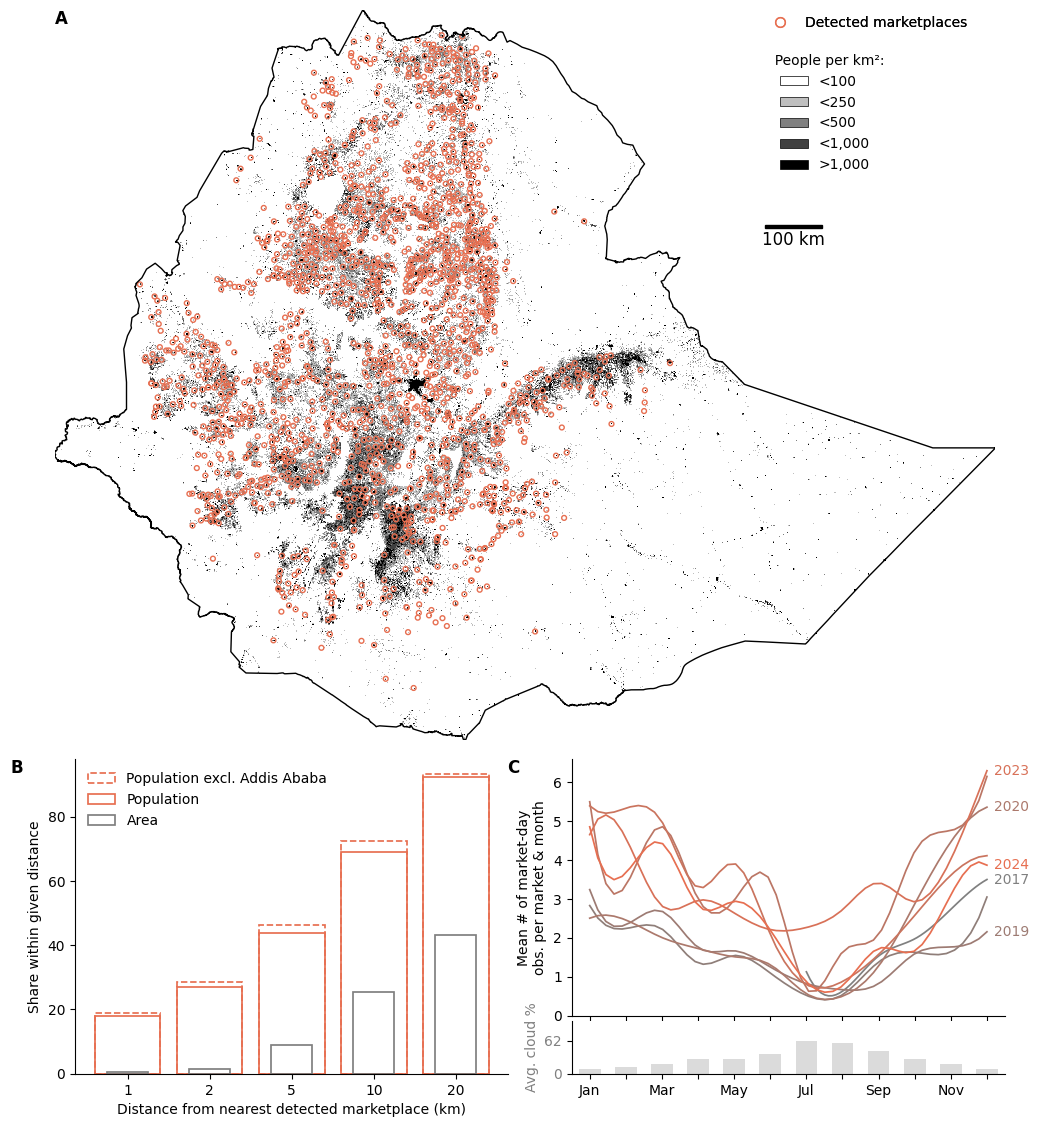

In [75]:
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm

# 1. Stage One: Create figure and plot ax1
fig = plt.figure(figsize=(12, 12), dpi=100, constrained_layout=True)
g = 32  # grid granularity
gs = GridSpec(g, g, figure=fig)

# ax1: Top panel spanning full width of top 24 rows
ax1 = fig.add_subplot(gs[:20, :])
plot_population_and_markets(ax1, 0.75, 0.67)

# 2. Stage Two: Add the lower two panels afterward
ax2 = fig.add_subplot(gs[21:, : int(g / 2) - 1])
ax3 = fig.add_subplot(gs[21:30, int(g / 2) + 1:])
ax4 = fig.add_subplot(gs[30:, int(g / 2) + 1:])

pop_share_plot(ax2)
obs_per_month(ax3)
add_cloud_bar(ax4)
plt.show()


## Table S2

In [77]:
query = f"""
       SELECT marketLat, marketLon, marketDays FROM `mai-database`.`location_file` lf
        WHERE to_delete IS NULL
        AND 00DownStatus IN ("complete","updating")
        AND country="{country}"
        AND (false_positive IN (-1,0) OR false_positive IS NULL)
        AND EXISTS(
            SELECT 1 FROM process_runs pr2
            WHERE pr2.Location=lf.Location
            AND Setup="MpM6"
            AND Status="complete"
        )
        AND NOT EXISTS(
            SELECT 1 FROM process_runs pr
            WHERE pr.Location=lf.Location
            AND Setup="MpM6" 
            AND runAnyway="no"
        )
        """

def create_gdf_from_markets(df):
    """Convert a DataFrame with 'marketLat' and 'marketLon' into a GeoDataFrame."""
    df["geometry"] = df.apply(
        lambda row: Point(row["marketLon"], row["marketLat"]), axis=1
    )
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  # Assuming WGS84


def shpFromQuery(query):
    df = pd.read_sql(query, engine)
    df = df[df["marketLat"].notnull()]
    gdf = create_gdf_from_markets(df)
    print("# markets:", len(gdf))
    return gdf


market_centroids = shpFromQuery(query)

market_centroids['marketDays'] = market_centroids['marketDays'].astype(str)
market_centroids['comma_count'] = market_centroids['marketDays'].astype(str).str.count(',')
market_centroids['marketDaysCount'] = market_centroids['comma_count']+1
average = market_centroids['marketDaysCount'].mean()
print("Number of market days on average: ",average)
print("frequency of market days",  market_centroids['marketDaysCount'].value_counts().sort_index())
mkts_w_2_mktdays = market_centroids[market_centroids['comma_count']==1]

# Split on comma and remove curly braces and whitespace
mkts_w_2_mktdays[['mktday1', 'mktday2']] = (
    mkts_w_2_mktdays['marketDays']
    .str.strip('{}')                # remove curly braces
    .str.replace("'", "", regex=False)  # remove single quotes
    .str.replace('"', "", regex=False)  # remove double quotes
    .str.split(',', expand=True)   # split into columns
    .apply(lambda col: col.str.strip().astype(float))  # strip spaces and convert to float
)

mkts_w_2_mktdays['diff'] = abs(mkts_w_2_mktdays['mktday1']-mkts_w_2_mktdays['mktday2'])
freq_table = mkts_w_2_mktdays['diff'].value_counts().sort_index()
print(freq_table)

# Load the shapefile
gdf = gpd.read_file('forFigures/ETH_20250630.shp')

# Ensure the GeoDataFrame has a projected CRS (in meters) for accurate area calculation
# If it's in a geographic CRS (degrees), reproject it first, e.g., to UTM
if gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=32633)  # Replace 32633 with the appropriate UTM zone EPSG code for your data

# Calculate area in square meters
gdf['area_sqm'] = gdf.geometry.area

# Convert to hectares (1 ha = 10,000 sqm)
gdf['area_ha'] = gdf['area_sqm'] / 10000

# Calculate average area in hectares
average_area_ha = gdf['area_ha'].mean()

print(f"Average size of shapes: {average_area_ha:.2f} hectares")

# markets: 1710
Number of market days on average:  1.087719298245614
frequency of market days marketDaysCount
1    1570
2     130
3      10
Name: count, dtype: int64
diff
1.0     4
2.0    10
3.0    73
4.0    32
5.0     2
6.0     9
Name: count, dtype: int64
Average size of shapes: 0.86 hectares


## Table S3   

True positives: 1381
False positives: 39
True negatives: 2716
False negatives: 340
Share of true positives among positives: 97.3%
Share of false negatives among marketplaces: 19.8%


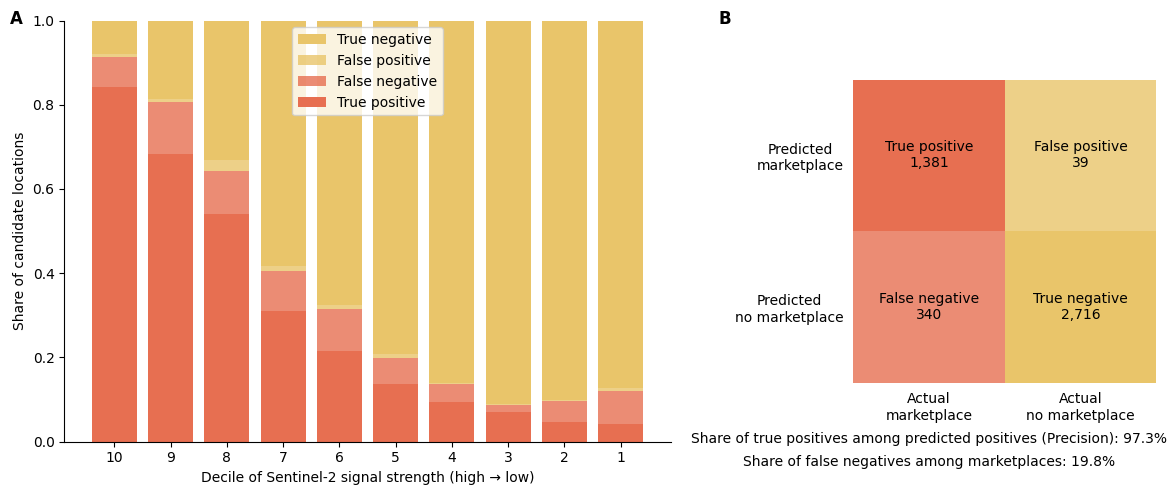

In [78]:
# Confusion matrix

query_tp = '''
    SELECT Location FROM location_file lf 
    WHERE country ="Ethiopia"
    AND false_positive=0
'''

query_fp = '''
    SELECT Location FROM location_file lf 
    WHERE country ="Ethiopia"
    AND false_positive=1
'''

query_tn = '''
    SELECT Location FROM location_file lf 
    WHERE country ="Ethiopia"
    AND EXISTS(
        SELECT 1 FROM process_runs pr
        WHERE lf.Location=pr.Location
        AND Setup="MpM6"
        AND (runAnyway = 'no' OR (minStrictnessRank>20 AND runAnyway IS NULL) OR Status="failed")
    )
    '''

query_fn = '''
    SELECT Location FROM location_file lf 
    WHERE country ="Ethiopia"
    AND EXISTS(
        SELECT 1 FROM process_runs pr
        WHERE lf.Location=pr.Location
        AND minStrictnessRank>20
        AND runAnyway = 'yes'
    )
'''

df_tp = pd.read_sql(query_tp, engine)
df_fp = pd.read_sql(query_fp, engine)
df_tn = pd.read_sql(query_tn, engine)
df_fn = pd.read_sql(query_fn, engine)

TP = len(df_tp)
FP = len(df_fp)
TN = len(df_tn)
FN = len(df_fn)

# Compute share metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
fn_rate = FN / (TP + FN) if (TP + FN) > 0 else 0


print(f"True positives: {len(df_tp)}")
print(f"False positives: {len(df_fp)}")
print(f"True negatives: {len(df_tn)}")
print(f"False negatives: {len(df_fn)}")
print(f"Share of true positives among positives: {len(df_tp) / (len(df_tp) + len(df_fp)):.1%}")
print(f"Share of false negatives among marketplaces: {len(df_fn) / (len(df_tp) + len(df_fn)):.1%}")

# Processesing the signal data for a specific country by grouping into quantiles.
# Locations with minStrictnessRank > 20 should still be treated as true positives in quantile-wise detection calculations if runAnyway="yes" in the database.
query = f'''
SELECT
    lf.Location,
    lf.maxSignal,
    lf.false_positive,
    pr.minStrictnessRank,
    pr.runAnyway
FROM
    location_file lf
JOIN
    process_runs pr ON lf.Location = pr.Location
WHERE lf.country="{country}"
    AND maxSignal > 0
    AND pr.Setup="MpM6"
    AND Status IN ('complete','failed')
LIMIT 10000
'''
cnx = mysql.connector.connect(user='root', password='BMkjM8_)-tN8R33u', host='34.72.234.161', database='mai-database')
cursor = cnx.cursor()
cursor.execute(query)
response = cursor.fetchall()
cnx.close()
cursor.close()

# Creating a condition that checks if the query result is empty 
# if empty, it will print a warning message and exits the function to prevent further processing of nonexistent data.

quantiles=10
# Creating DataFrame
df = pd.DataFrame(response, columns=['Location', 'maxSignal','false_positive', 'minStrictnessRank', 'runAnyway']).sort_values(by='maxSignal')#sorts dataframe by maxSignal in ascending order
df['maxSignal'] = pd.to_numeric(df['maxSignal'])


df['quantile'] = pd.qcut(df['maxSignal'], quantiles, labels=False, duplicates="drop") # Divides maxSignal values into quantiles and assigns each row a quantile index.

# Compute total candidate locations screened and locations where minStrictnessRank <= 20 and adds runAnyway
total_locs_screened = df.shape[0]
total_locs_min_rank = ((df['minStrictnessRank'] <= 20) & (df['false_positive'] != 1)).sum()
total_locs_run_anyway = (df['runAnyway'] == "yes").sum()
total_locs_false_pos = (df['false_positive'] == 1).sum()
lambda x: ((x < 20) | (df.loc[x.index, 'runAnyway'] == "yes"))
# Create a bar chart for the country

# Create a combined figure with 2 subplots side-by-side
fig, (ax_bar, ax_conf) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [2, 1]})

# === Bar Chart ===
decile_summary = df.groupby('quantile').agg(
    share_with_true_positive=('minStrictnessRank', lambda x: ((x < 20) &  (df.loc[x.index, 'false_positive'] != 1)).mean()),
    share_with_false_negative=('runAnyway', lambda x: (x == "yes").mean()),
    share_with_false_positive=('false_positive', lambda x: (x == 1).mean()),
    min_maxSignal=('maxSignal', 'min')
).reset_index()

decile_summary['share_with_true_negative'] = 1 - decile_summary['share_with_true_positive'] - decile_summary['share_with_false_positive'] - decile_summary['share_with_false_negative']
decile_summary['quantile'] = decile_summary['quantile'] + 1

bars1 = ax_bar.bar(decile_summary['quantile'].astype(str), decile_summary['share_with_true_positive'], label='True positive', color=color3)
bars2 = ax_bar.bar(decile_summary['quantile'].astype(str), decile_summary['share_with_false_negative'], bottom=decile_summary['share_with_true_positive'], label='False negative', color=color3, alpha=0.8)
bars3 = ax_bar.bar(decile_summary['quantile'].astype(str), decile_summary['share_with_false_positive'], bottom=decile_summary['share_with_true_positive'] + decile_summary['share_with_false_negative'], label='False positive', color=color1, alpha=0.8)
bars4 = ax_bar.bar(decile_summary['quantile'].astype(str), decile_summary['share_with_true_negative'], bottom=decile_summary['share_with_true_positive'] + decile_summary['share_with_false_negative'] + decile_summary['share_with_false_positive'], label='True negative', color=color1)

ax_bar.set_xlabel("Decile of Sentinel-2 signal strength (high → low)")
ax_bar.set_ylabel("Share of candidate locations")
ax_bar.set_ylim(0, 1)
ax_bar.invert_xaxis()
ax_bar.spines["top"].set_visible(False)
ax_bar.spines["right"].set_visible(False)
handles, labels = ax_bar.get_legend_handles_labels()
ax_bar.legend(handles[::-1], labels[::-1],loc="upper center")


# === Confusion Matrix ===
conf_values = [['True positive', 'False positive'], ['False negative', 'True negative']]
conf_counts = [[TP, FP], [FN, TN]]  # Example counts, replace with your real numbers
conf_colors = [[color3,to_rgba(color1, alpha=0.8)], [to_rgba(color3, alpha=0.8), color1]]

for i in range(2):
    for j in range(2):
        rect = patches.Rectangle((j, i), 1, 1, facecolor=conf_colors[i][j])
        ax_conf.add_patch(rect)
        ax_conf.text(j + 0.5, i + 0.5,
                     f"{conf_values[i][j]}\n{conf_counts[i][j]:,}",
                     ha='center', va='center',  color='black')

ax_conf.set_xticks([0.5, 1.5])
ax_conf.set_xticklabels(['Actual\nmarketplace', 'Actual\nno marketplace'])
ax_conf.set_yticks([0.5, 1.5])
ax_conf.set_yticklabels(['Predicted\nmarketplace', 'Predicted\nno marketplace'])
ax_conf.set_xlim(0, 2)
ax_conf.set_ylim(0, 2)
ax_conf.invert_yaxis()
ax_conf.set_aspect('equal')
ax_conf.tick_params(left=False, bottom=False)

fig.text(0.01, 0.98, "A", fontsize=12, fontweight="bold", ha="left", va="top")
fig.text(0.6, 0.98, "B", fontsize=12, fontweight="bold", ha="left", va="top")

for label in ax_conf.get_xticklabels() + ax_conf.get_yticklabels():
    label.set_multialignment('center')

# Metrics below the figure
ax_conf.text(0.5, 2.4, f"Share of true positives among predicted positives (Precision): {precision:.1%}", ha='center', fontsize=10)
ax_conf.text(0.5, 2.55, f"Share of false negatives among marketplaces: {fn_rate:.1%}", ha='center', fontsize=10)
ax_conf.spines["top"].set_visible(False)
ax_conf.spines["right"].set_visible(False)
ax_conf.spines["bottom"].set_visible(False)
ax_conf.spines["left"].set_visible(False)

plt.tight_layout()
plt.show()


## Figure S1

# markets: 60
# markets: 49
# markets: 38


lat      lon                  geometry
0  -15.9746  34.4630   POINT (34.463 -15.9746)
1  -16.0933  34.6145  POINT (34.6145 -16.0933)
2  -15.4722  34.6505  POINT (34.6505 -15.4722)
3  -15.3998  34.6563  POINT (34.6563 -15.3998)
4  -15.3004  34.6797  POINT (34.6797 -15.3004)
5  -15.5932  34.6980   POINT (34.698 -15.5932)
6  -15.4460  34.7787   POINT (34.7787 -15.446)
7  -16.0444  34.8035  POINT (34.8035 -16.0444)
8  -15.4476  34.8547  POINT (34.8547 -15.4476)
9  -16.2744  34.8708  POINT (34.8708 -16.2744)
10 -16.4600  34.8824    POINT (34.8824 -16.46)
11 -15.2243  34.8899  POINT (34.8899 -15.2243)
12 -16.4883  34.8937  POINT (34.8937 -16.4883)
13 -15.4636  34.9430   POINT (34.943 -15.4636)
14 -15.9094  34.9538  POINT (34.9538 -15.9094)
15 -14.9884  34.9568  POINT (34.9568 -14.9884)
16 -16.2000  35.0148     POINT (35.0148 -16.2)
17 -14.9108  35.0552  POINT (35.0552 -14.9108)
18 -16.5778  35.1064  POINT (35.1064 -16.5778)
19 -16.4090  35.1615   POINT (35.1615 -16.409)
20 -14.8419  35.1714  POINT (35.1714 -14.8419)
21 -14.6383  35.1809  POINT (35.1809 -14.6383)
22 -16.9801  35.2169  POINT (35.2169 -16.9801)
23 -15.0625  35.2186  POINT (35.2186 -15.0625)
24 -14.4823  35.2544  POINT (35.2544 -14.4823)
25 -16.9203  35.2551  POINT (35.2551 -16.9203)
26 -16.7810  35.2792   POINT (35.2792 -16.781)
27 -14.4675  35.2865  POINT (35.2865 -14.4675)
28 -16.8482  35.2950   POINT (35.295 -16.8482)
29 -15.6801  35.3223  POINT (35.3223 -15.6801)
30 -14.1831  35.4464  POINT (35.4464 -14.1831)
31 -14.3620  35.4511   POINT (35.4511 -14.362)
32 -14.9975  35.4952  POINT (35.4952 -14.9975)
33 -14.8700  35.5286    POINT (35.5286 -14.87)
34 -14.7175  35.5524  POINT (35.5524 -14.7175)
35 -15.8082  35.6374  POINT (35.6374 -15.8082)
36 -15.7171  35.6926  POINT (35.6926 -15.7171)
37 -14.7099  35.8029  POINT (35.8029 -14.7099)

pre (33.765370000000004, 35.47983000000001) 0.07793000000000001
pre (33.5946, 36.6713) 0.13985000000000003
pre (35.050095, 40.974805) 0.26930499999999996


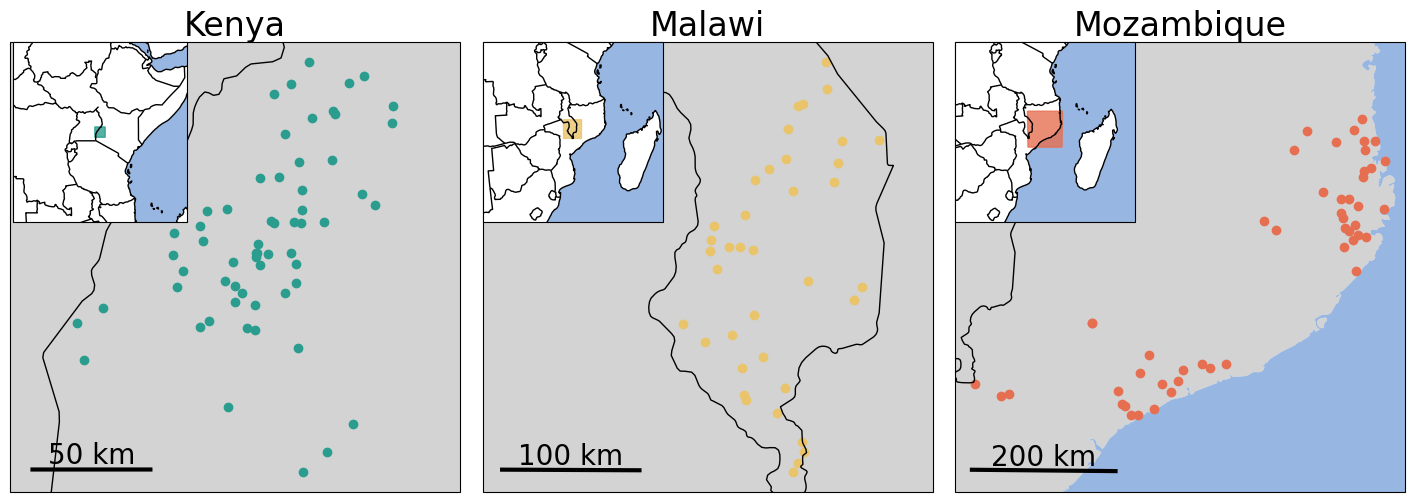

In [79]:
def create_gdf_from_markets(df):
    """Convert a DataFrame with 'marketLat' and 'marketLon' into a GeoDataFrame."""
    df["geometry"] = df.apply(
        lambda row: Point(row["lon"], row["lat"]), axis=1
    )
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")  # Assuming WGS84

def shpFromQuery(country):
    query = f"""
       SELECT lat, lon FROM `mai-database`.`location_file` lf
        WHERE country="{country}"
        AND validation=1
               """
    df = pd.read_sql(query, engine)
    df = df[df["lat"].notnull()]
    gdf = create_gdf_from_markets(df)
    print("# markets:", len(gdf))
    return gdf

kenya_df = shpFromQuery('Kenya')
mozambique_df = shpFromQuery('Mozambique')
malawi_df = shpFromQuery('malawi')
display(malawi_df)


def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3, unit="km"):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + 2*length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx+ length * 500, sby, str(length) + f' {unit}', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', fontsize=20)

def plot_map(ax, df, country, color):
    """Generate a map with specified coordinates on the given axes."""
    clon = list(df['lon'])
    clat = list(df['lat'])
    minlon = min(clon)
    maxlon = max(clon)
    minlat = min(clat)
    maxlat = max(clat)
    central_lon = np.mean([minlon, maxlon])
    central_lat = np.mean([minlat, maxlat])
    
    # Main map
    extent_values = [maxlon - minlon, maxlat - minlat]
    larger_extent = max(extent_values)
    larger_extent_index = np.argmax(extent_values)
    add = extent_values[larger_extent_index]/20
    ext_lon = ((central_lon  -add- larger_extent/2), (central_lon  +add+ larger_extent/2))
    ext_lat = ((central_lat  -add- larger_extent/2), (central_lat  +add+ larger_extent/2))
    print('pre',ext_lon,add)
    #ext_lon = ((central_lon  - larger_extent/2)*0.995, (central_lon  + larger_extent/2)*1.005)
    #print('post',ext_lon)
    if country=="Malawi":
        ax.set_extent([ext_lon[0]-.5, ext_lon[1]-.5, ext_lat[0], ext_lat[1]], crs=ccrs.PlateCarree())
    else:
        ax.set_extent([ext_lon[0], ext_lon[1], ext_lat[0], ext_lat[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, linestyle='-')
    #img = PIL.Image.open('forFigures/eo_base_2020_clean_geo.tif')
    #img_extent = (-180, 180, -90, 90)
    #ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), alpha=.3)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)
    if country=="Kenya":
        scale_bar(ax, 50,(0.05,0.05))
    elif country=="Mozambique":
        scale_bar(ax, 200,(0.05,0.05))
    elif country=="Malawi":
        scale_bar(ax, 100,(0.05,0.05))
        
    ax.set_title(country, y=1.0, pad=5, fontsize = 24)
    
    # Plotting points
    #if country=="Kenya":
    #    gdf = gpd.read_file('forFigures/siaya_villages_bounding.shp')
    #    gdf.plot(ax=ax, color= maincolors[2], edgecolor='none', alpha=0.3)
    #    ax.scatter(siaya['mkt_lon'], siaya['mkt_lat'], color = 'gray', label='Points', transform=ccrs.PlateCarree(), marker='s', s=100)
    ax.scatter(df['lon'], df['lat'], color = color, label='Points', transform=ccrs.PlateCarree())
    # Inset map
    
    ax_inset = ax.inset_axes([0, 0.6, 0.4, 0.4], 
                             projection=ccrs.Orthographic(central_longitude=central_lon, 
                                                          central_latitude=central_lat))
    ax_inset.set_extent([central_lon - 15, central_lon + 15, central_lat - 15, central_lat + 15], crs=ccrs.PlateCarree())
    ax_inset.add_feature(cfeature.OCEAN)
    ax_inset.add_feature(cfeature.LAND, facecolor='white')
    ax_inset.add_feature(cfeature.COASTLINE)
    ax_inset.add_feature(cfeature.BORDERS, linestyle='-')
    rectangle = Rectangle((ext_lon[0], ext_lat[0]), ext_lon[1] - ext_lon[0], ext_lat[1] - ext_lat[0], 
                          linewidth=1, edgecolor=color, facecolor=color, alpha=0.8,
                          transform=ccrs.PlateCarree())
    ax_inset.add_patch(rectangle)

dfs = [kenya_df, malawi_df, mozambique_df]
maincolors = ['#2A9D8F','#E9C46A','#E76F51']
country_names = ['Kenya', 'Malawi', 'Mozambique']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

for ax,df, country, color in zip(axes, dfs, country_names, maincolors):
    plot_map(ax, df, country, color)

plt.savefig(f"FigureS4.png", bbox_inches='tight', pad_inches=0, dpi=300)    
plt.show()
plt.close()   

## Figure S2   

Location      lat      lon  market                 geometry
0     lon10_0047lat38_2509  10.0047  38.2509       1  POINT (38.2509 10.0047)
1     lon10_0114lat38_8886  10.0114  38.8886       1  POINT (38.8886 10.0114)
2      lon10_0194lat39_248  10.0194  39.2480       1   POINT (39.248 10.0194)
3     lon10_0568lat38_9943  10.0568  38.9943       1  POINT (38.9943 10.0568)
4     lon10_1195lat39_6614  10.1195  39.6614       1  POINT (39.6614 10.1195)
...                    ...      ...      ...     ...                      ...
4471   lon37_4593lat6_4702   6.4702  37.4593       1   POINT (37.4593 6.4702)
4472   lon37_4593lat6_4701   6.4701  37.4593       1   POINT (37.4593 6.4701)
4473  lon37_4715lat10_4209  10.4209  37.4715       1  POINT (37.4715 10.4209)
4474  lon38_1119lat13_1741  13.1741  38.1119       1  POINT (38.1119 13.1741)
4475  lon37_4287lat13_5889  13.5889  37.4287       1  POINT (37.4287 13.5889)

[4476 rows x 5 columns]

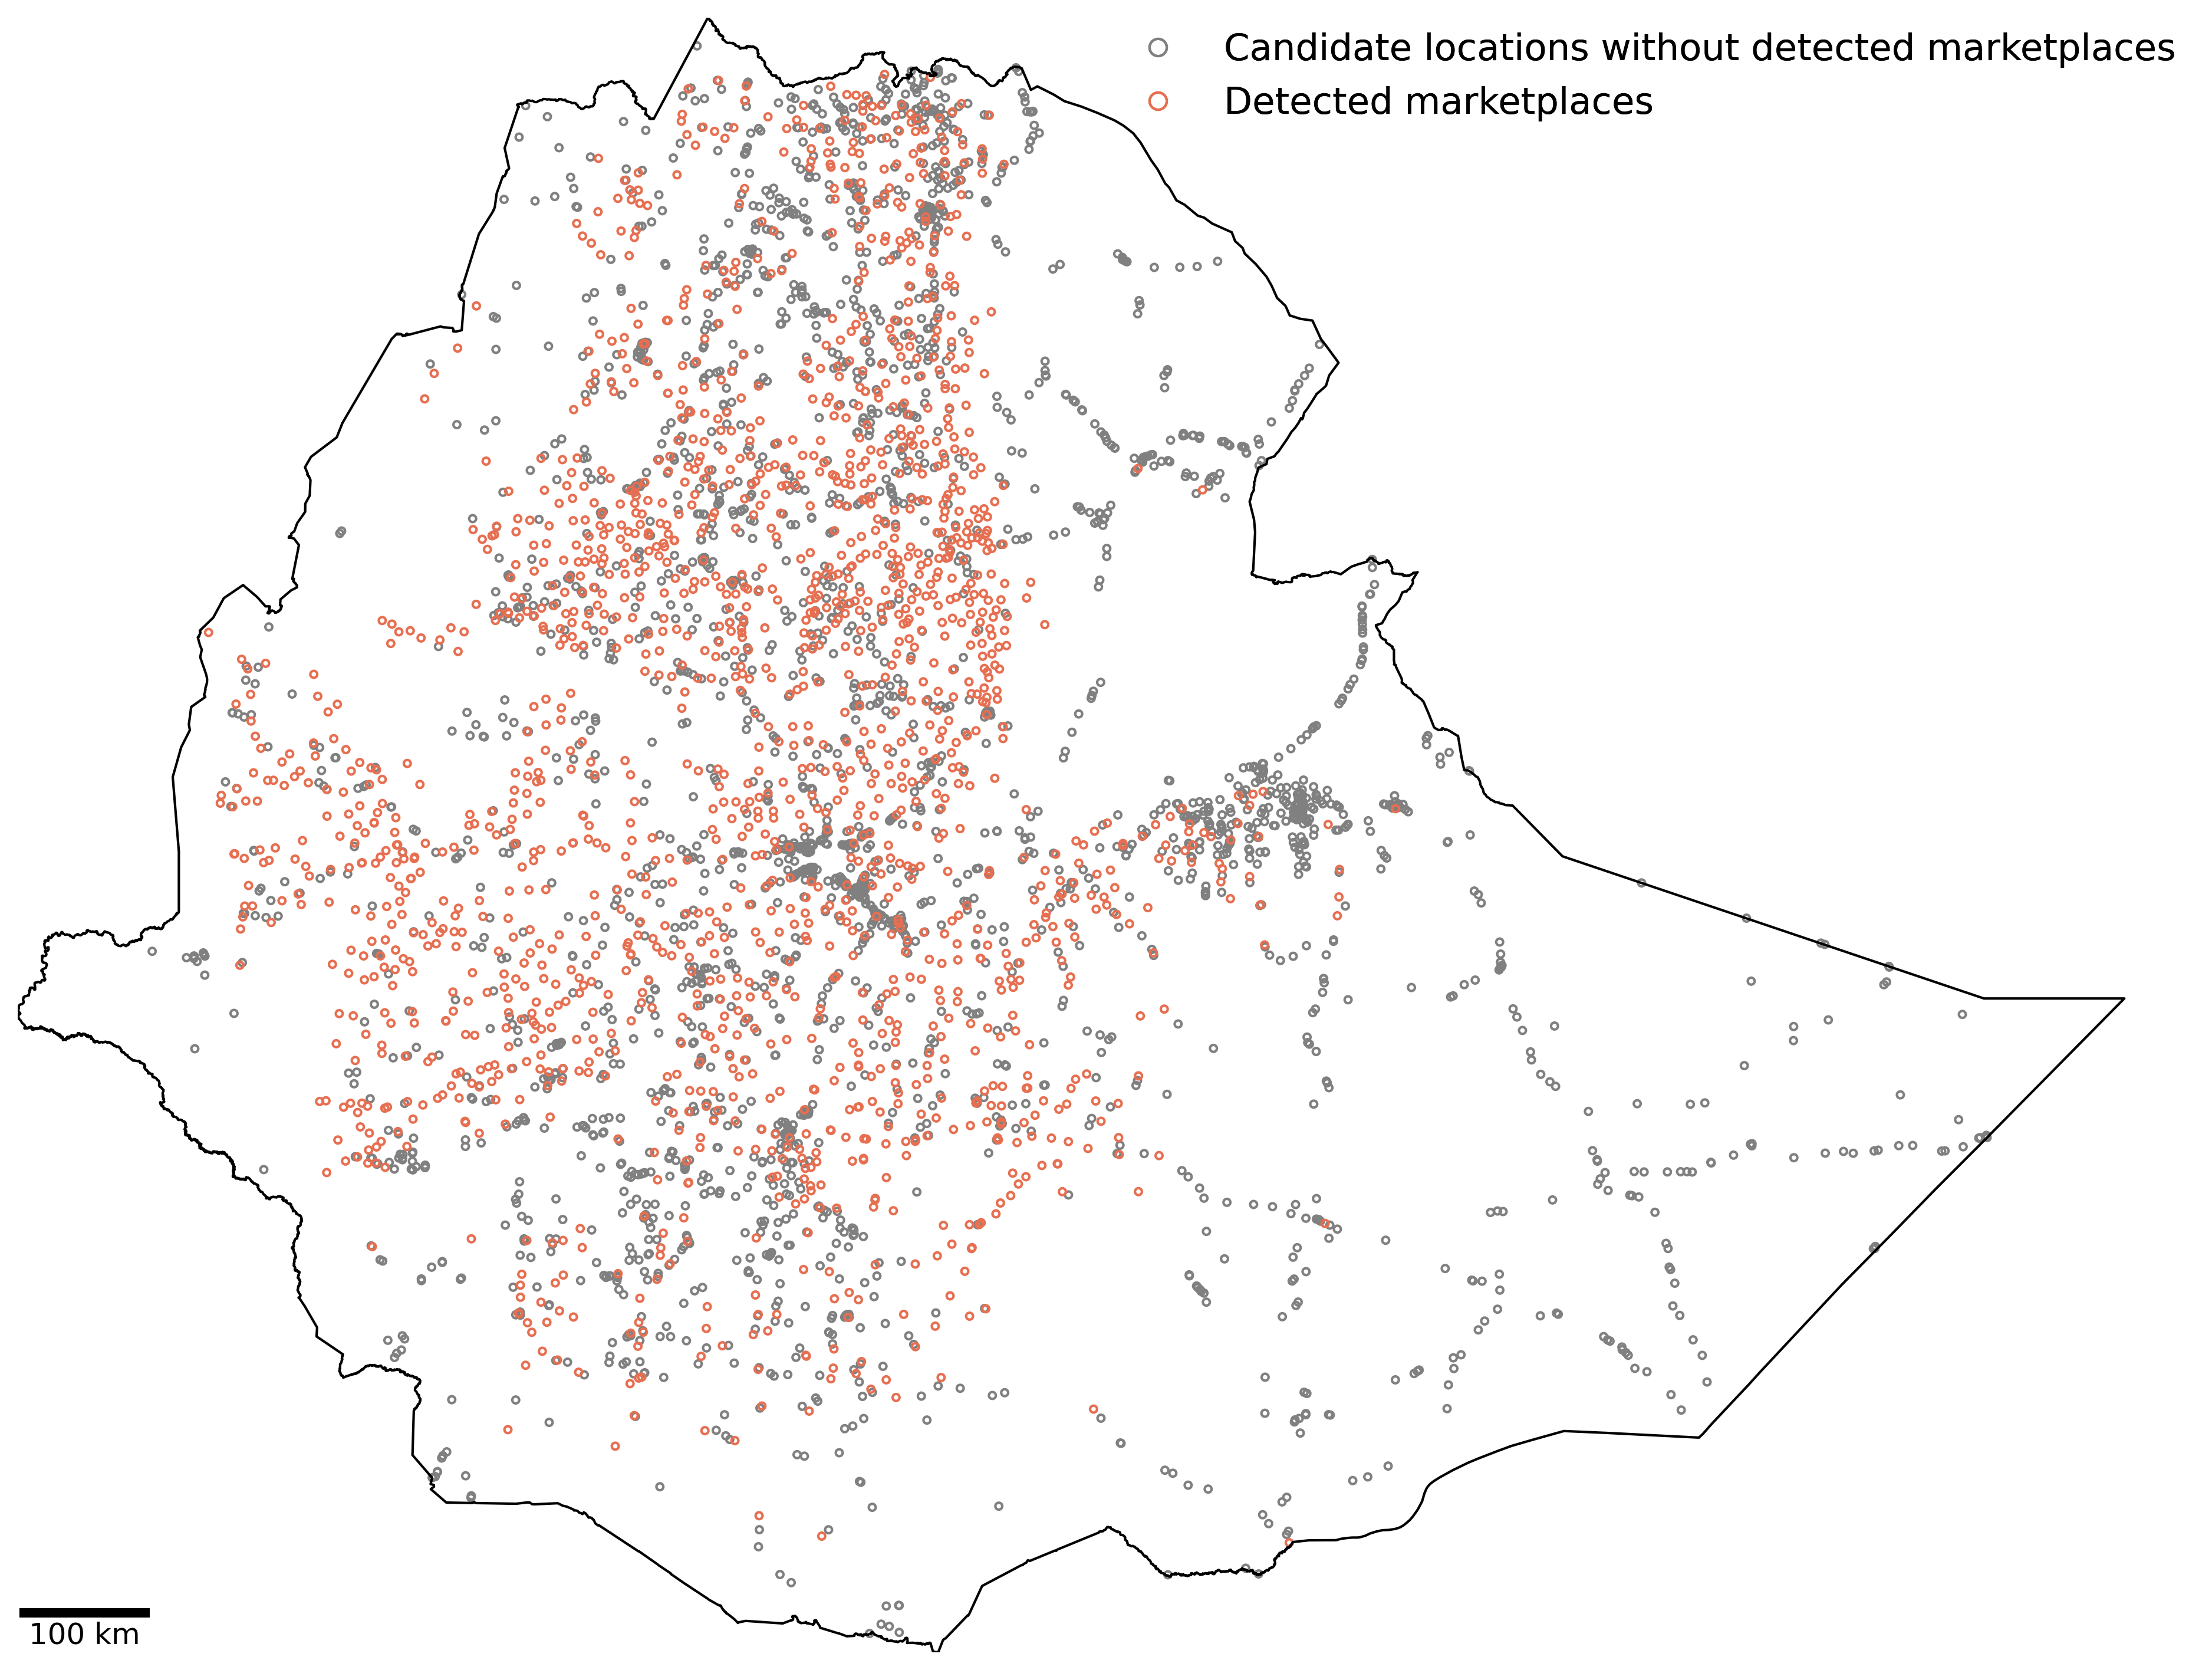

In [80]:

query_tp = '''
    SELECT Location, lat, lon FROM location_file lf 
    WHERE country ="Ethiopia"
    AND false_positive=0
'''

query_fp = '''
    SELECT Location, lat, lon FROM location_file lf 
    WHERE country ="Ethiopia"
    AND false_positive=1
'''

query_tn = '''
    SELECT Location, lat, lon FROM location_file lf 
    WHERE country ="Ethiopia"
    AND EXISTS(
        SELECT 1 FROM process_runs pr
        WHERE lf.Location=pr.Location
        AND Setup="MpM6"
        AND (runAnyway = 'no' OR (minStrictnessRank>20 AND runAnyway IS NULL) OR Status="failed")
    )
    '''

query_fn = '''
    SELECT Location, lat, lon FROM location_file lf 
    WHERE country ="Ethiopia"
    AND EXISTS(
        SELECT 1 FROM process_runs pr
        WHERE lf.Location=pr.Location
        AND minStrictnessRank>20
        AND runAnyway = 'yes'
    )
'''

df_tp = pd.read_sql(query_tp, engine)
df_tp['market']=1
df_fp = pd.read_sql(query_fp, engine)
df_fp['market']=0
df_tn = pd.read_sql(query_tn, engine)
df_tn['market']=0
df_fn = pd.read_sql(query_fn, engine)
df_fn['market']=1

df_all = pd.concat([df_tp, df_fp, df_tn, df_fn], ignore_index=True)
geometry = [Point(xy) for xy in zip(df_all['lon'], df_all['lat'])]

# Create GeoDataFrame, specifying coordinate reference system (CRS)
df_all = gpd.GeoDataFrame(df_all, geometry=geometry, crs="EPSG:4326")  # WGS84 lat/lon
display(df_all)

# )  # Create a figure with size 16x16 inches
def plot_population_and_markets_add(ax):
    # Read the raster data
    # Plot the market centroids (assuming market_centroids is already a GeoDataFrame with the 'geometry' column)

    df_all[df_all['market'] == 0].plot(
        ax=ax, facecolor="none", edgecolor="0.5", marker="o", markersize=8, label="Candidate locations without confirmed marketplaces", alpha=1
    )
    df_all[df_all['market'] == 1].plot(
        ax=ax, facecolor="none", edgecolor=color3, marker="o", markersize=8, label="Detected marketplaces", alpha=1
    )
    # Plot the Ethiopia boundaries
    eth_boundaries.plot(ax=ax, color="none", edgecolor="black", linewidth=1)


    legend_title = mpatches.Patch(
        facecolor='none',  # Transparent fill
        edgecolor='none',  # No border
        label="People per km²:"  # Leading spaces to align
    )

    candidate_legend = mlines.Line2D(
        [],
        [],
        color="gray",  # or any color you like
        marker="o",
        markerfacecolor="none",
        markeredgecolor="gray",
        linestyle="none",
        markersize=7,
        label="Candidate locations without detected marketplaces",
    )

    market_legend = mlines.Line2D(
        [],
        [],
        color=color3,
        markerfacecolor="none",
        linestyle="none",
        markeredgecolor=color3,
        marker="o",
        markersize=7,
        label="Detected marketplaces",
    )

    #leg.get_title().set_multialignment("center")
    
    legend1 = ax.legend(handles=[candidate_legend,market_legend], loc='upper left', frameon=False, bbox_to_anchor=(0.5, 1), borderaxespad=0, fontsize=15)
    ax.add_artist(legend1)

    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(
        ax.transData,
        longitude_degrees,
        f"{km} km",
        "lower left",
        pad=0,
        color="black",
        frameon=False,
        size_vertical=0.05,
        fontproperties=fontprops,
    )

    ax.add_artist(scalebar)

    # Set the minimum limit for the y-axis to this latitude and an arbitrary max limit
    ax.set_ylim(bottom=eth_boundaries.total_bounds[1], top=eth_boundaries.total_bounds[3])
    ax.set_xlim(left=eth_boundaries.total_bounds[0], right=eth_boundaries.total_bounds[2]+0.5)

    # Add labels and display the map
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis("off")
 
    plt.show()

fig, ax = plt.subplots(figsize=(16, 12), dpi=300)
plot_population_and_markets_add(ax)

## Figure S5

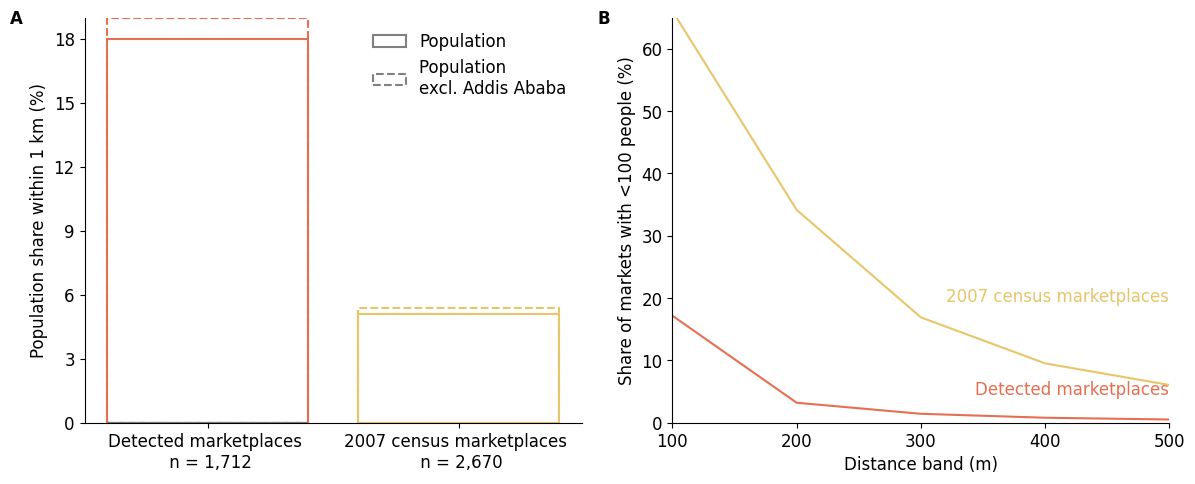

In [82]:
country = 'Ethiopia'

# Load EE FeatureCollections
grid_w_pop = ee.FeatureCollection(f"projects/planetupload/assets/cleanedLocs/{country}_ringsghsl")
grid_w_pop_without_addis = ee.FeatureCollection(f"projects/planetupload/assets/cleanedLocs/{country}_ringsghsl_withoutaddis")
grid_w_pop_census = ee.FeatureCollection(f"projects/planetupload/assets/cleanedLocs/{country}_censusMarkets_ringsghsl")
grid_w_pop_without_addis_census = ee.FeatureCollection(f"projects/planetupload/assets/cleanedLocs/{country}_censusMarkets_ringsghsl_withoutaddis")

# Convert to GeoDataFrames
df_b = geemap.ee_to_gdf(grid_w_pop)
df_b_noaddis = geemap.ee_to_gdf(grid_w_pop_without_addis)
df_b_census = geemap.ee_to_gdf(grid_w_pop_census)
df_b_noaddis_census = geemap.ee_to_gdf(grid_w_pop_without_addis_census)

# Merge on 'radius'
df_b = df_b.merge(df_b_noaddis[['radius', 'population']], on='radius', how='left', suffixes=('', '_noaddis'))
df_b = df_b.merge(df_b_census[['radius', 'population']], on='radius', how='left', suffixes=('', '_census'))
df_b = df_b.merge(df_b_noaddis_census[['radius', 'population']], on='radius', how='left', suffixes=('', '_noaddis_census'))

# Rename columns for clarity
df_b.rename(columns={
    'population': 'population_all',
    'population_noaddis': 'population_without_addis',
    'population_census': 'population_census',
    'population_noaddis_census': 'population_census_without_addis'
}, inplace=True)

# Calculate population shares (%)
total_population = 109_628_500
total_population_noaddis = 103_971_800
df_b['pop_share_all'] = 100 * df_b['population_all'] / total_population
df_b['pop_share_without_addis'] = 100 * df_b['population_without_addis'] / total_population_noaddis
df_b['pop_share_census'] = 100 * df_b['population_census'] / total_population
df_b['pop_share_census_without_addis'] = 100 * df_b['population_census_without_addis'] / total_population_noaddis

# Filter for 1km radius
df_1km = df_b[df_b['radius'] == 1000].copy()

# ---------------------------------------------
# Load data for line chart
city_geom = ee.FeatureCollection("projects/ethiopia-candidate-locs/assets/cityMask").first().geometry()
census_markets = ee.FeatureCollection(
    f"projects/planetupload/assets/cleanedLocs/{country}_censusMarkets_popProximity_withoutAddis"
).filter(
    ee.Filter.intersects('.geo', city_geom).Not()
)
mai_markets = ee.FeatureCollection(f"projects/planetupload/assets/cleanedLocs/{country}_maiMarkets_popProximity_withoutAddis")

df_census = geemap.ee_to_gdf(census_markets)
df_mai = geemap.ee_to_gdf(mai_markets)

# Extract population columns within 500m
pop_cols = sorted([col for col in df_census.columns if col.startswith('pop_')], key=lambda x: int(x.split('_')[1].replace('m', '')))
pop_cols = [col for col in pop_cols if int(col.split('_')[1].replace('m', '')) <= 500]
distances = [int(col.split('_')[1].replace('m', '')) for col in pop_cols]

# Calculate shares under threshold
threshold = 100
shares_census = 100* (df_census[pop_cols] < threshold).sum() / len(df_census)
shares_mai = 100*(df_mai[pop_cols] < threshold).sum() / len(df_mai)

# ---------------------------------------------
# PLOTTING: Side-by-side plots
plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

## --- A. Bar Chart ---
x = [0, 1]
width = 0.35

# Bars: actual data (hidden from legend)
ax1.bar(x[0], df_1km['pop_share_without_addis'].values[0], color="none", edgecolor=color3, linewidth=1.5, linestyle="--", label="_nolegend_")
ax1.bar(x[0], df_1km['pop_share_all'].values[0], color="none", edgecolor=color3, linewidth=1.5, label="_nolegend_")
ax1.bar(x[1], df_1km['pop_share_census_without_addis'].values[0], color="none", edgecolor=color1, linewidth=1.5, linestyle="--", label="_nolegend_")
ax1.bar(x[1], df_1km['pop_share_census'].values[0], color="none", edgecolor=color1, linewidth=1.5, label="_nolegend_")

# Dummy bars for legend
ax1.bar(0, 0, color="none", edgecolor="gray", linestyle="-", linewidth=1.5, label="Population")
ax1.bar(0, 0, color="none", edgecolor="gray", linestyle="--", linewidth=1.5, label="Population \nexcl. Addis Ababa")

# Formatting
ax1.set_xticks(x)
ax1.set_xticklabels(['Detected marketplaces \n n = 1,712', '2007 census marketplaces \n n = 2,670'])
ax1.set_ylabel('Population share within 1 km (%)')
ax1.set_yticks([0, 3, 6, 9, 12, 15, 18])
ax1.set_ylim(0, 19)
ax1.legend(frameon=False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(False)

# Label
ax1.text(-0.15, 1.02, "A", transform=ax1.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")

## --- B. Line Chart ---
ax2.plot(distances, shares_census, linestyle='solid', color=color1,linewidth=1.5)
ax2.plot(distances, shares_mai, linestyle='solid', color=color3,linewidth=1.5)

# Annotation
ax2.text(1, 0.3, "2007 census marketplaces", color=color1, fontsize=12, transform=ax2.transAxes, ha='right')
ax2.text(1, 0.07, "Detected marketplaces", color=color3, fontsize=12, transform=ax2.transAxes, ha='right')

# Formatting
ax2.set_xlabel('Distance band (m)')
ax2.set_ylabel('Share of markets with <100 people (%)')
ax2.set_xticks(distances)
ax2.set_xlim([100, 500])
ax2.set_ylim([0, 65])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.grid(False)

# Label
ax2.text(-0.15, 1.02, "B", transform=ax2.transAxes, fontsize=12, fontweight="bold", va="top", ha="left")

plt.tight_layout()
plt.show()
